# **TP 2 Analisis Predictivo**
-  Juan Ignacio Scorza
- link a la competencia: https://www.kaggle.com/competitions/analisis-predictivo-2023q1/data





## Cargar Dataset


In [200]:
import pandas as pd
import numpy as np

# Establecer el número máximo de filas y columnas a mostrar
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [201]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c analisis-predictivo-2023q1


import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive
analisis-predictivo-2023q1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [202]:
df = pd.read_csv("base_train.csv", sep=",")
df_val = pd.read_csv("base_val.csv", sep=",")

## EDA 
(*base_train*)





In [ ]:
#Imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *  

In [ ]:
df.head(20)

**Shape**

In [ ]:
df.shape


 **Duplicados**

In [ ]:
df.duplicated().sum()

In [ ]:
duplicates = df.duplicated(subset=df.columns.difference(['id'])).sum()

print("Cantidad de filas duplicadas (excluyendo 'id'):", duplicates)


**Columas** y **Types** 

In [ ]:
df.columns

In [ ]:
df.dtypes

In [ ]:
df['host_id'] = df['host_id'].astype(str)
df['id'] = df['id'].astype(str)


price esta en object, crear proximamente la variable price_num

**Describe**

In [ ]:
df.describe()

### Nulls/Missings

In [ ]:
import pandas as pd

# Calcular la cantidad de valores nulos por columna
null_counts = df.isnull().sum()

# Obtener los tipos de dato de cada columna
column_types = df.dtypes

# Combinar los resultados en un nuevo DataFrame
null_info = pd.concat([null_counts, column_types], axis=1, keys=['Cantidad de Nulos', 'Tipo de Dato'])

# Filtrar las columnas donde null_counts sea mayor a cero
null_columns = null_info.loc[null_counts > 0]

# Mostrar las columnas con valores nulos y su tipo de dato
print(null_columns)




In [ ]:
df[null_columns.index].head(20)

**Observar los valores mas frecuentes que toma cada variable(de las que tienen nulls)**

In [ ]:
import pandas as pd

# Iterar sobre las columnas del DataFrame
for column in df[null_columns.index].columns:
    # Obtener el conteo de valores únicos en la columna
    value_counts = df[column].value_counts()
    
    # Mostrar los 10 valores más comunes en la columna
    print(f"Columna: {column}")
    print(value_counts.head(10))
    print()


IMPUTAR MISSINGS DE VARIABLES **CATEGORICAS**

      

*   description --> "none" 
*   neighborhood_overview --> "none"
*   host_about --> "none"
*   host_response_time --> "unknown"
*   host_is_superhost --> "f" (es uno solo)
*
*   Las dos siguientes las pasamos como unknown, probablemente las terminemos sacando por redundantes con neigbourhood_cleansed
*   host_neighbourhood --> "unknown"
*   neighbourhood --> "unknown"
*
*   neighbourhood_group_cleansed --> se borra (todos null)
*   bathrooms_text --> "unknown" (son 9)
*   license --> "unknown" (son 98)









In [ ]:
df['description'].fillna('none', inplace=True)
df['neighborhood_overview'].fillna('none', inplace=True)
df['host_about'].fillna('none', inplace=True)
df['host_response_time'].fillna('unknown', inplace=True)
df['host_is_superhost'].fillna('f', inplace=True)
df['bathrooms_text'].fillna('unknown', inplace=True)
df['license'].fillna('unknown', inplace=True)
df['host_neighbourhood'].fillna('unknown', inplace=True)
df['neighbourhood'].fillna('unknown', inplace=True)

if 'neighbourhood_group_cleansed' in df.columns:
    df.drop('neighbourhood_group_cleansed', axis=1, inplace=True)
    print("La variable 'neighbourhood_group_cleansed' ha sido eliminada del DataFrame.")
else:
    print("La variable 'neighbourhood_group_cleansed' no existe en el DataFrame.")
 





*  host_location 

se imputan los valores con la host location asociada a neighbourhood_cleansed

In [ ]:
missing_host_location = df[df['host_location'].isnull()]

neighborhood_counts = missing_host_location['neighbourhood_cleansed'].value_counts()
print(neighborhood_counts)


In [ ]:
neighbourhood_location_map = df.groupby('neighbourhood_cleansed')['host_location'].apply(lambda x: x.mode()[0]).to_dict()
df['host_location'] = df.apply(lambda x: neighbourhood_location_map[x['neighbourhood_cleansed']] if pd.isnull(x['host_location']) else x['host_location'], axis=1)
print(df['host_location'].isna().sum())

*   host_acceptance_rate 

pasamos a float

imputamos con la media

In [ ]:
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)
df['host_acceptance_rate'].describe()

In [ ]:
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean(), inplace=True)



print(df['host_acceptance_rate'].mean())

*   host_response_rate 

pasamos a float

imputamos con una regresion lineal de host_time_exp



In [ ]:
import datetime
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['host_response_rate'].describe()

df['host_since'] = pd.to_datetime(df['host_since'])


now = datetime.datetime.now()
df['host_time_exp'] = (now - df['host_since']).dt.days

In [ ]:
from sklearn.linear_model import LinearRegression

# Dividir el conjunto de datos en dos grupos: conocidos y desconocidos
known_data = df.dropna(subset=['host_response_rate'])
unknown_data = df[df['host_response_rate'].isna()]

# Definir las variables independientes (X) y dependiente (y)
X = known_data[['host_time_exp']]
y = known_data['host_response_rate']

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir los valores faltantes de host_response_rate
imputed_response_rate = model.predict(unknown_data[['host_time_exp']])

# Reemplazar los valores faltantes en el conjunto de datos original
df.loc[df['host_response_rate'].isna(), 'host_response_rate'] = imputed_response_rate


IMPUTAR MISSINGS DE VARIABLES **NUMERICAS**

```
# 
bathrooms                                 4928   -->  se crean de bathroom_text
bedrooms                                   240   -->  se imputan con otras var
beds                                        70   -->  se imputan con otras var
calendar_updated                          4928   -->  drop
review_scores_accuracy                       4   -->  drop 
review_scores_cleanliness                    4   -->  drop
review_scores_checkin                        4   -->  drop
review_scores_communication                  4   -->  drop
review_scores_location                       4   -->  drop
review_scores_value                          4   -->  drop
```







*   bathrooms (la imputamos con la variable bathroom_text)
        A tener en cuenta: sacamos solo la cantidad de banos, su condicion de privado/compartido la tendremos en cuenta en otra variable.  



In [ ]:
import re

def extract_bathrooms(text):
    pattern = r"(\d+\.?\d*)"
    match = re.search(pattern, text)
    if match:
        return float(match.group(1))
    elif text == 'unknown':
        return 0
    elif 'half' in text.lower():
        return 0.5
    else:
        return None

df['bathrooms'] = df['bathrooms_text'].apply(extract_bathrooms)
df['bathrooms'].describe()




*   bedrooms (240) --> imputamos en relacion a beds/bathrooms/accommodates



hacemos un test de correlacion de bedrooms con otras variables para saber con cuales es logico imputar

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las correlaciones con la variable "bedrooms"
correlations = df.corr()['bedrooms'].sort_values(ascending=False)

# Eliminar la correlación de "bedrooms" consigo misma
correlations = correlations.drop('bedrooms')

# Graficar las correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.title('Correlaciones con la variable "bedrooms"')
plt.show()


usaremos "beds//bathrooms//accommodates" para imputar, variables que logicamente estan relacionadas con la cantidad de dormitorios.

In [ ]:
import pandas as pd
import numpy as np

# Paso 1: Filtrar filas con valores faltantes en "bedrooms"
missing_bedrooms = df[df['bedrooms'].isnull()]

# Paso 2: Iterar sobre las filas faltantes y buscar valores similares en las otras variables
for index, row in missing_bedrooms.iterrows():
    beds = row['beds']
    bathrooms = row['bathrooms']
    accommodates = row['accommodates']
    
    # Paso 3: Filtrar filas con valores similares en las otras variables
    similar_rows = df[(df['beds'] == beds) & (df['bathrooms'] == bathrooms) & (df['accommodates'] == accommodates)]
    
    # Paso 4: Imputar el valor mediano de "bedrooms" de las filas similares
    median_bedrooms = similar_rows['bedrooms'].median()
    df.loc[index, 'bedrooms'] = median_bedrooms

#quedan algunos sin imputar asiq lo hacemos con la moda = mediana 

# Calcular la moda general de la variable "bedrooms"
mode_bedrooms = df['bedrooms'].mode()[0]

# Imputar los valores faltantes con la moda general
df['bedrooms'].fillna(mode_bedrooms, inplace=True)

df['bedrooms'].isna().sum()





*   beds (70) --> imputamos en relacion a bathrooms bedrooms y accommodates



hacemos un test de correlacion de beds con otras variables para saber con cuales es logico imputar

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las correlaciones con la variable "bedrooms"
correlations = df.corr()['beds'].sort_values(ascending=False)

# Eliminar la correlación de "beds" consigo misma
correlations = correlations.drop('beds')

# Graficar las correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.title('Correlaciones con la variable "beds"')
plt.show()

usamos entonces bedrooms//bathrooms//accommodates para imputar

In [ ]:
import pandas as pd
import numpy as np

# Paso 1: Filtrar filas con valores faltantes en "bedrooms"
missing_bedrooms = df[df['beds'].isnull()]

# Paso 2: Iterar sobre las filas faltantes y buscar valores similares en las otras variables
for index, row in missing_bedrooms.iterrows():
    bedrooms = row['bedrooms']
    bathrooms = row['bathrooms']
    accommodates = row['accommodates']
    
    # Paso 3: Filtrar filas con valores similares en las otras variables
    similar_rows = df[(df['bedrooms'] == bedrooms) & (df['bathrooms'] == bathrooms) & (df['accommodates'] == accommodates)]
    
    # Paso 4: Imputar el valor mediano de "beds" de las filas similares
    median_bedrooms = similar_rows['beds'].median()
    df.loc[index, 'beds'] = median_bedrooms

#quedan algunos sin imputar asiq lo hacemos con la moda = mediana 

# Calcular la moda general de la variable "beds"
mode_bedrooms = df['beds'].mode()[0]

# Imputar los valores faltantes con la moda general
df['beds'].fillna(mode_bedrooms, inplace=True)

df['beds'].isna().sum()

hay 4 filas que tienen missing en las siguientes variables:

review_scores_accuracy

review_scores_cleanliness

review_scores_checkin

review_scores_communication

review_scores_location

review_scores_value

***se descartan de la base.***

In [ ]:
df.dropna(subset=['review_scores_cleanliness'], inplace=True)


todos los campos de calendar_updated son missings, descartamos por ahora la variable 

In [ ]:
df.drop('calendar_updated', axis=1, inplace=True)


**Asi queda el df sin datos nulos ni missings**

In [ ]:
print("datos nulos: ")
print(df.isnull().sum().sum())


### Outliers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'df' con todas tus variables

# Filtra solo las columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Elimina las variables 'longitude' y 'latitude' de la lista de columnas numéricas
numeric_columns = numeric_columns.drop(['longitude', 'latitude'])

# Calcula el número de filas y columnas para el subplot
n_rows = int(np.ceil(len(numeric_columns) / 3))
n_cols = 3

# Crea el subplot con el tamaño deseado
fig, axs = plt.subplots(n_rows, n_cols, figsize=(22, 10))

# Itera sobre cada columna numérica y crea un boxplot en el subplot correspondiente
for i, column in enumerate(numeric_columns):
    row = i // n_cols
    col = i % n_cols
    
    # Crea el boxplot para la columna actual
    sns.boxplot(x=df[column], ax=axs[row, col])
    axs[row, col].set_xlabel(column)
    
    # Verifica si hay outliers en la columna actual
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    has_outliers = any((df[column] < lower_bound) | (df[column] > upper_bound))
    
    # Si hay outliers, cambia el color del título a rojo
    if has_outliers:
        axs[row, col].set_xlabel(column, color='red')
    
# Elimina los subplots vacíos si hay menos variables que subplots
if len(numeric_columns) < n_rows * n_cols:
    for i in range(len(numeric_columns), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axs[row, col])

# Ajusta el espaciado entre los subplots
fig.tight_layout()

# Muestra el gráfico de cajas
plt.show()



A simple vista se ven algunos outliers en varias variables pero ninguno parece representar un valor imposible o poco probable, se tiene en cuenta que debe haber hosts de airbnb con muchos rentas distintas muy grandes que van a destacar por sobre otros que posean una sola propiedad.

*    host listings count 

In [ ]:
df[df['host_listings_count']>100].sort_values(by='host_listings_count',ascending=False).head(20)




In [ ]:
df = df.drop(df[df['host_listings_count']>100].index)

no parecen ser casos irreales, pero si pueden complicar el modelo, por lo que se eliminan algunos valores extremos

*    host total listings count

In [ ]:
df[df['host_total_listings_count']>400].sort_values(by='host_total_listings_count',ascending=False).head(20)


In [ ]:
df = df.drop(df[df['host_total_listings_count']>400].index)

*   number_of_reviews


In [ ]:
df[df['number_of_reviews']>1000].sort_values(by='number_of_reviews',ascending=False).head(20)


In [ ]:
df = df.drop(df[df['number_of_reviews']>1000].index)

*   number of reviews ltm
*   number of reviews l30d

---
con el ajuste de la var anterior se fueron los extremos


In [ ]:
df[df['number_of_reviews_l30d']>50].sort_values(by='number_of_reviews_ltm',ascending=False).head(20)


*    minimum nights

In [ ]:
df[df['minimum_nights']>200]

In [ ]:
df = df.drop(df[df['minimum_nights']>200].index)

*    minimum maximum nights

> se encontro que hay unicamente dos valores por encima de 1125, pero mas de dosmil que son =1125, por el momento eliminamos los dos extremos 



In [ ]:
df[df['minimum_maximum_nights']>1125]

In [ ]:
df = df.drop(df[df['minimum_maximum_nights']>1125].index)

### Target y correlaciones    

*    review_scores_rating

In [ ]:

plt.hist(df['review_scores_rating'], bins=10)
plt.xlabel('Puntaje de calificación')
plt.ylabel('Frecuencia')
plt.title('Distribución de review_scores_rating')
plt.show()

In [ ]:
sns.boxplot(data=df, y='review_scores_rating')
plt.ylabel('Puntaje de calificación')
plt.title('Boxplot de review_scores_rating')
plt.show()


In [ ]:
stats = df['review_scores_rating'].describe()

print(stats)

corr de la target contra otras

In [ ]:
# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Crear el gráfico de dispersión y distribuciones
sns.pairplot(numeric_df, y_vars='review_scores_rating')

In [ ]:


# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Calcular la correlación entre "review_scores_rating" y las demás variables numéricas
correlations = numeric_df.corr()['review_scores_rating']

# Eliminar la correlación consigo misma (valor de 1)
correlations = correlations.drop('review_scores_rating')

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Generar el gráfico de barras
barplot = sns.barplot(x=correlations.index, y=correlations.values, ax=ax)

# Establecer los nombres de las variables en el eje x
ax.set_xticklabels(correlations.index, rotation=45, ha='right')

# Etiquetas de los ejes
ax.set_xlabel('Variables')
ax.set_ylabel('Correlación')

# Modificar el color de las etiquetas de las variables según la correlación
for i, bar in enumerate(barplot.patches):
    if correlations[i] > 0.2 or correlations[i] < -0.2:
        bar.set_color('red')

# Mostrar el gráfico
plt.show()


In [ ]:

# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Calcular la correlación entre "review_scores_rating" y las demás variables numéricas
correlations = numeric_df.corr()['review_scores_rating']

# Eliminar la correlación consigo misma (valor de 1)
correlations = correlations.drop('review_scores_rating')

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(14, 7))

# Generar el gráfico de barras
barplot = sns.barplot(x=correlations.values, y=correlations.index, ax=ax)

# Modificar el color del label de la variable según la correlación
for i, bar in enumerate(barplot.patches):
    if correlations[i] > 0.2 or correlations[i] < -0.2:
        barplot.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, correlations.index[i], ha='left', color='black')

# Etiquetas de los ejes
ax.set_xlabel('Correlación')
ax.set_ylabel('Variables')

# Mostrar el gráfico
plt.show()


In [ ]:
# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Calcular la matriz de correlaciones
correlation_matrix = numeric_df.corr()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(24, 12))

# Generar la matriz de correlaciones gráfica
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax)

# Mostrar el gráfico
plt.show()

### Creacion de Variables



*   Creamos host_country y host_city_or_state a partir de la host_location



In [ ]:
host_location_counts = df['host_location'].value_counts()
print(host_location_counts.to_string())


In [ ]:
def process_host_location(location):
    if ',' in location:
        city, country = location.split(',')
        if country.strip() in ['DC', 'IL', 'CA', 'RI', 'FL', 'CO', 'NY']:
            country = 'United States'
        return city.strip(), country.strip()
    else:
        return location.strip(), ''


df[['host_city_or_state', 'host_country']] = df['host_location'].apply(process_host_location).apply(pd.Series)




*   Creamos la variable price_num
y ajustamos outliers

(no cambiamos la categorica ya que quizas le demos uso a futuro)



In [ ]:
# Remover caracteres no numéricos y convertir a float
df['price_num'] = df['price'].str.replace('[^\d.]', '', regex=True).astype(float)

# Verificar los resultados
print(df[['price', 'price_num']].head(50))

*   price_num

In [ ]:
df[df['price_num']>5000]

In [ ]:
df = df.drop(df[df['price_num']>5000].index)

*  Creamos host_time_exp que me dice los dias de experiencia que tiene siendo host a partir de la host_since y hoy. 

In [ ]:
import datetime

df['host_since'] = pd.to_datetime(df['host_since'])


now = datetime.datetime.now()
df['host_time_exp'] = (now - df['host_since']).dt.days




*   Creamos la variable shared_bathrooms que dice 1 si hay banos compartidos y 0 si son banos privados a partir de bathrooms_text



In [ ]:
df['shared_bathrooms'] = df['bathrooms_text'].str.contains('shared', case=False).astype(int)


In [ ]:
def count_unique_values_and_top_values(df):
    # Obtener las columnas categóricas
    categorical_columns = df.select_dtypes(include='object').columns.tolist()

    # Crear un diccionario para almacenar los resultados
    result = {}

    # Contar los valores únicos y obtener los 5 valores más comunes en cada columna categórica
    for column in categorical_columns:
        unique_values = df[column].nunique()
        top_values = df[column].value_counts().head(5).index.tolist()
        result[column] = {'unique_values': unique_values, 'top_values': top_values}

    return result

    # Obtener la cantidad de valores únicos en cada columna categórica
result = count_unique_values_and_top_values(df)

# Imprimir los resultados
for column, count in result.items():
    print(f"{column}: {count}")

In [ ]:



def count_unique_values(df):
    # Obtener las columnas categóricas
    categorical_columns = df.select_dtypes(include='object').columns.tolist()

    # Crear un diccionario para almacenar los resultados
    unique_values = {}

    # Contar los valores únicos en cada columna categórica
    for column in categorical_columns:
        unique_values[column] = df[column].nunique()

    return unique_values


# Obtener la cantidad de valores únicos en cada columna categórica
result = count_unique_values(df)

# Imprimir los resultados
for column, count in result.items():
    print(f"{column}: {count}")


*    creamos source_bin variable  1 = 'city scrape' 0 = 'previous scrape'

In [ ]:
# Crear la variable source_bin
df['source_bin'] = df['source'].apply(lambda x: 1 if x == 'city scrape' else 0)

# Verificar los resultados
print(df['source_bin'].value_counts())
print(df['source'].value_counts())

*    creamos host_is_superhost_bin 1=t 0=f

In [ ]:

# Función personalizada para asignar valores a host_is_superhost_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_is_superhost_bin
df['host_is_superhost_bin'] = df['host_is_superhost'].apply(map_superhost)

# Verificar los resultados
print(df['host_is_superhost_bin'].value_counts())
print(df['host_is_superhost'].value_counts())



*   creamos host_has_profile_pic_bin   1=t 0=f



In [ ]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_has_profile_pic_bin
df['host_has_profile_pic_bin'] = df['host_has_profile_pic'].apply(map_superhost)

# Verificar los resultados
print(df['host_has_profile_pic_bin'].value_counts())
print(df['host_has_profile_pic'].value_counts())




*   creamos host_identity_verified_bin   1=t 0=f



In [ ]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_identity_verified_bin
df['host_identity_verified_bin'] = df['host_identity_verified'].apply(map_superhost)

# Verificar los resultados
print(df['host_identity_verified_bin'].value_counts())
print(df['host_identity_verified'].value_counts())




*   creamos has_availability_bin   1=t 0=f



In [ ]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable has_availability_bin
df['has_availability_bin'] = df['has_availability'].apply(map_superhost)

# Verificar los resultados
print(df['has_availability_bin'].value_counts())
print(df['has_availability'].value_counts())




*   creamos calendar_last_scraped_bin   1= '2022-12-05'  0= '2022-12-17'



In [ ]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['2022-12-05', 'T']:
        return 1
    elif value in ['2022-12-17', 'F']:
        return 0
    else:
        return None

# Crear la variable calendar_last_scraped_bin
df['calendar_last_scraped_bin'] = df['calendar_last_scraped'].apply(map_superhost)

# Verificar los resultados
print(df['calendar_last_scraped_bin'].value_counts())
print(df['calendar_last_scraped'].value_counts())




*   creamos instant_bookable_bin   1= t  0= f



In [ ]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ["f", 'F']:
        return 0
    else:
        return None

# Crear la variable instant_bookable_bin
df['instant_bookable_bin'] = df['instant_bookable'].apply(map_superhost)

# Verificar los resultados
print(df['instant_bookable_bin'].value_counts())
print(df['instant_bookable'].value_counts())


*  host_verifications

---
se crearan 3 variables binarias para indicar si se posee o no esa verificacion y 1 variable mas que cuenta la cantidad de verificaciones


In [ ]:
df['host_verifications'].unique()

In [ ]:


# Obtener las verificaciones únicas
unique_verifications = ['phone', 'email', 'work_email']

# Crear las columnas binarias
for verification in unique_verifications:
    df[f'has_{verification}'] = 0

# Agregar la columna verification_count
df['verification_count'] = 0

# Función para contar la cantidad de verificaciones
def count_verifications(verifications):
    return len(verifications)

# Recorrer la columna "host_verifications" y establecer los valores de las columnas binarias y verification_count
for i, row in df.iterrows():
    verifications = row['host_verifications']
    df.at[i, 'verification_count'] = count_verifications(verifications)
    for verification in unique_verifications:
        if verification in verifications:
            df.at[i, f'has_{verification}'] = 1


**Frequency Encoding**


---

realizaremos prueba con frequency encoding para los campos en los que se tiene una cantidad de entre 3 y 110 valores posibles.




'host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood',
                         'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text',
                         'host_city_or_state', 'host_country'

In [ ]:
categorias = df.select_dtypes(include='object').columns.tolist()

result_freq = [categoria for categoria in categorias if 3 <= df[categoria].nunique() <= 110]
print(result_freq)

In [ ]:
# Variables a las que se les aplicará frequency encoding
variables_categoricas = ['host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood',
                         'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text',
                         'host_city_or_state', 'host_country']

# Iterar sobre las variables y aplicar frequency encoding
for variable in variables_categoricas:
    frecuencias = df[variable].value_counts(normalize=True)  # Calcular las frecuencias relativas
    df[f'{variable}_freq_encoded'] = df[variable].map(frecuencias)  # Mapear las frecuencias a cada categoría


In [ ]:
df.head()

## EDA sin quitar outliers. 
(*base_train*)





In [203]:
#Imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *  

In [204]:
df.head(20)

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,528022,city scrape,Somewhere Else,Highlights<br />*Located only 5 minutes from C...,NaN,2594559,Els,2012-06-10,"Amsterdam, Netherlands",NaN,within a day,87%,96%,f,Spaarndammer en Zeeheldenbuurt,1,1,"['email', 'phone']",t,t,NaN,Westerpark,NaN,52.39114,4.88846,Private room in boat,Private room,2,NaN,1.5 baths,1.0,1.0,"[""Bed linens"", ""Dishes and silverware"", ""Hange...",$100.00,2,30,2,2,30,30,2.0,30.0,NaN,t,4,16,29,212,2022-12-05,248,37,3,2016-10-06,2022-11-28,4.85,4.88,4.83,4.93,4.90,4.78,4.72,0363 9289 A94D 5C21 A579,f,1,0,1,0,3.30
1,2818,city scrape,Quiet Garden View Room & Super Fast Wi-Fi,Quiet Garden View Room & Super Fast Wi-Fi<br /...,"Indische Buurt (""Indies Neighborhood"") is a ne...",3159,Daniel,2008-09-24,"Amsterdam, Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,100%,t,Indische Buurt,1,1,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,52.36435,4.94358,Private room in rental unit,Private room,2,NaN,1.5 shared baths,1.0,2.0,"[""Books and reading material"", ""Smoke alarm"", ...",$59.00,3,28,3,3,1125,1125,3.0,1125.0,NaN,t,6,27,27,27,2022-12-05,314,29,1,2009-03-30,2022-11-06,4.89,4.93,4.99,4.97,4.98,4.69,4.81,0363 5F3A 5684 6750 D14D,f,1,0,1,0,1.88
2,20168,previous scrape,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,59484,Alexander,2009-12-02,"Amsterdam, Netherlands",+ (Phone number hidden by Airbnb),within an hour,100%,98%,f,Grachtengordel,3,5,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Centrum-Oost,NaN,52.36407,4.89393,Private room in townhouse,Private room,2,NaN,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Hangers"", ""Wifi...",$106.00,1,365,1,1,1125,1125,1.0,1125.0,NaN,t,0,0,0,0,2022-12-05,339,0,0,2010-03-02,2020-04-09,4.44,4.69,4.79,4.63,4.62,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.18
3,27886,city scrape,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",97647,Flip,2010-03-23,"Amsterdam, Netherlands","Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100%,100%,t,Westelijke Eilanden,1,1,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Centrum-West,NaN,52.38761,4.89188,Private room in houseboat,Private room,2,NaN,1.5 baths,1.0,1.0,"[""Books and reading material"", ""Smoke alarm"", ...",$140.00,2,356,2,2,1125,1125,2.0,1125.0,NaN,t,0,17,32,40,2022-12-05,243,17,5,2012-01-09,2022-11-27,4.94,4.93,4.95,4.95,4.92,4.89,4.79,0363 974D 4986 7411 88D8,t,1,0,1,0,1.83
4,28871,city scrape,Comfortable double room,<b>The space</b><br />In a monumental ho

**Shape**

In [205]:
df.shape


(4928, 68)

 **Duplicados**

In [206]:
df.duplicated().sum()

0

In [207]:
duplicates = df.duplicated(subset=df.columns.difference(['id'])).sum()

print("Cantidad de filas duplicadas (excluyendo 'id'):", duplicates)


Cantidad de filas duplicadas (excluyendo 'id'): 0


**Columas** y **Types** 

In [208]:
df.columns

Index(['id', 'source', 'name', 'description', 'neighborhood_overview',
       'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365',

In [209]:
df.dtypes

id                                                int64
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
host_id                                           int64
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_neighbourhood                               object
host_listings_count                               int64
host_total_listings_count                         int64
host_verifications                              

In [210]:
df['host_id'] = df['host_id'].astype(str)
df['id'] = df['id'].astype(str)


price esta en object, crear proximamente la variable price_num

**Describe**

In [211]:
df.describe()

,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4928.000000,4928.000000,0.0,4928.000000,4928.000000,4928.000000,0.0,4688.000000,4858.000000,4928.000000,4928.000000,4928.000000,4928.000000,4.928000e+03,4.928000e+03,4928.000000,4.928000e+03,0.0,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000
mean,2.508929,4.768872,NaN,52.367291,4.890984,2.915381,NaN,1.569966,1.910045,4.702110,503.834416,4.508117,5.233157,4.364088e+05,4.364412e+05,4.834963,4.364305e+05,NaN,4.704951,12.687703,20.998580,78.667817,60.731128,13.894886,0.944196,4.812330,4.846438,4.757839,4.879411,4.888109,4.788587,4.650321,1.919846,0.953734,0.847808,0.052963,1.159996
std,10.565612,28.580679,NaN,0.016869,0.035833,1.418921,NaN,0.895077,1.611142,32.613639,524.417130,32.562465,32.829427,3.059105e+07,3.059105e+07,32.701807,3.059105e+07,NaN,7.256038,17.054934,27.511634,110.944191,106.865390,33.908213,3.081784,0.264727,0.214052,0.292974,0.206738,0.216055,0.225730,0.268705,2.664493,1.379593,2.154187,0.507139,2.504318
min,1.000000,1.000000,NaN,52.290340,4.755710,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.000000,1.000000,NaN,52.356657,4.868110,2.000000,NaN,1.000000,1.000000,2.000000,21.000000,2.000000,2.000000,2.800000e+01,3.000000e+01,2.000000,3.000000e+01,NaN,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,0.000000,4.750000,4.790000,4.660000,4.840000,4.860000,4.680000,4.530000,1.000000,0.000000,0.000000,0.000000,0.250000
50%,1.000000,1.000000,NaN,52.366640,4.888395,2.000000,NaN,1.000000,1.000000,3.000000,177.000000,2.000000,3.000000,1.125000e+03,1.125000e+03,3.000000,1.125000e+03,NaN,0.000000,2.000000,5.000000,14.000000,22.000000,4.000000,0.000000,4.880000,4.900000,4.840000,4.940000,4.960000,4.840000,4.690000,1.000000,1.000000,0.000000,0.000000,0.510000
75%,2.000000,3.000000,NaN,52.376990,4.908610,4.000000,NaN,2.000000,2.000000,4.000000,1125.000000,3.000000,4.000000,1.125000e+03,1.125000e+03,4.000000,1.125000e+03,NaN,7.000000,23.000000,39.000000,132.000000,59.000000,13.000000,1.000000,4.990000,5.000000,4.960000,5.000000,5.000000,4.960000,4.810000,1.000000,1.000000,1.000000,0.000000,1.240000
max,363.000000,673.000000,NaN,52.425120,5.026430,16.000000,NaN,10.000000,33.000000,1001.000000,1825.000000,1001.000000,1001.000000,2.147484e+09,2.147484e+09,1001.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1875.000000,1352.000000,139.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,22.000000,14.000000,20.000000,8.000000,106.740000


### Nulls/Missings

In [212]:
import pandas as pd

# Calcular la cantidad de valores nulos por columna
null_counts = df.isnull().sum()

# Obtener los tipos de dato de cada columna
column_types = df.dtypes

# Combinar los resultados en un nuevo DataFrame
null_info = pd.concat([null_counts, column_types], axis=1, keys=['Cantidad de Nulos', 'Tipo de Dato'])

# Filtrar las columnas donde null_counts sea mayor a cero
null_columns = null_info.loc[null_counts > 0]

# Mostrar las columnas con valores nulos y su tipo de dato
print(null_columns)




                              Cantidad de Nulos Tipo de Dato
description                                   3       object
neighborhood_overview                      1348       object
host_location                               421       object
host_about                                 1746       object
host_response_time                         1662       object
host_response_rate                         1662       object
host_acceptance_rate                        776       object
host_is_superhost                             1       object
host_neighbourhood                         2124       object
neighbourhood                              1348       object
neighbourhood_group_cleansed               4928      float64
bathrooms                                  4928      float64
bathrooms_text                                9       object
bedrooms                                    240      float64
beds                                         70      float64
calendar_updated        

In [213]:
df[null_columns.index].head(20)

,description,neighborhood_overview,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,neighbourhood,neighbourhood_group_cleansed,bathrooms,bathrooms_text,bedrooms,beds,calendar_updated,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license
0,Highlights<br />*Located only 5 minutes from C...,NaN,"Amsterdam, Netherlands",NaN,within a day,87%,96%,f,Spaarndammer en Zeeheldenbuurt,NaN,NaN,NaN,1.5 baths,1.0,1.0,NaN,4.88,4.83,4.93,4.90,4.78,4.72,0363 9289 A94D 5C21 A579
1,Quiet Garden View Room & Super Fast Wi-Fi<br /...,"Indische Buurt (""Indies Neighborhood"") is a ne...","Amsterdam, Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,100%,t,Indische Buurt,"Amsterdam, North Holland, Netherlands",NaN,NaN,1.5 shared baths,1.0,2.0,NaN,4.93,4.99,4.97,4.98,4.69,4.81,0363 5F3A 5684 6750 D14D
2,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,"Amsterdam, Netherlands",+ (Phone number hidden by Airbnb),within an hour,100%,98%,f,Grachtengordel,"Amsterdam, North Holland, Netherlands",NaN,NaN,1 private bath,1.0,1.0,NaN,4.69,4.79,4.63,4.62,4.87,4.49,0363 CBB3 2C10 0C2A 1E29
3,Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.","Amsterdam, Netherlands","Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100%,100%,t,Westelijke Eilanden,"Amsterdam, North Holland, Netherlands",NaN,NaN,1.5 baths,1.0,1.0,NaN,4.93,4.95,4.95,4.92,4.89,4.79,0363 974D 4986 7411 88D8
4,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein","Amsterdam, Netherlands",Hi,within a few hours,100%,100%,t,Amsterdam Centrum,"Amsterdam, North Holland, Netherlands",NaN,NaN,1 shared bath,1.0,1.0,NaN,4.93,4.89,4.95,4.94,4.97,4.83,0363 607B EA74 0BD8 2F6F
5,This room can also accomodate 2 people. For a...,the street is quite lively especially on weeke...,"Amsterdam, Netherlands",Hi,within a few hours,100%,100%,t,Amsterdam Centrum,"Amsterdam, North Holland, Netherlands",NaN,NaN,1 shared bath,1.0,1.0,NaN,4.88,4.85,4.91,4.91,4.88,4.77,0363 607B EA74 0BD8 2F6F
6,Guests greatly appreciate the unique location ...,The appartment is located in the city centre. ...,"Amsterdam, Netherlands",Love to travel while hosting and to host while...,NaN,NaN,100%,f,Oostelijke Eilanden en Kadijken,"Amsterdam, Noord-Holland, Netherlands",NaN,NaN,1.5 baths,2.0,2.0,NaN,4.68,4.45,4.95,4.90,4.68,4.50,0363 E76E F06A C1DD 172C
7,Stylish & spacious guest suite in Amsterdam's ...,You will find yourself in a quiet side street ...,"Amsterdam, Netherlands",Joanna is from London and MP is from Amsterdam...,within a few hours,100%,92%,t,Grachtengordel,"Amsterdam, North Holland, Netherlands",NaN,NaN,1 bath,2.0,2.0,NaN,4.92,4.91,4.95,4.97,4.98,4.78,0363 576A D827 5085 6B83
8,B & B “De 9 Straatjes” welcomes you to your ‘h...,NaN,"Amsterdam, Netherlands",Hallo I am Raymond Living in Amsterdam and I h...,within an hour,100%,99%,t,Grachtengordel,NaN,NaN,NaN,1 private bath,1.0,1.0,NaN,4.90,4.88,4.87,4.85,4.94,4.83,0363 22DC 0E52 B70B 0FB8
9,All guests agree: the apartment is perfect an...,"Our neighborhood is very central, but also qui...","Amsterdam, Netherlands",Hi there! \r\n\r\nThank you for visiting my li...,within an hour,100%,25%,f,Museumkwartier,"Amsterdam, North Holland, Netherlands",NaN,NaN,1.5 baths,2.0,2.0,NaN,4.91,4.86,4.95,4.98,4.95,4.80,0363 B5A3 5F63 B032 A320


**Observar los valores mas frecuentes que toma cada variable(de las que tienen nulls)**

In [214]:
import pandas as pd

# Iterar sobre las columnas del DataFrame
for column in df[null_columns.index].columns:
    # Obtener el conteo de valores únicos en la columna
    value_counts = df[column].value_counts()
    
    # Mostrar los 10 valores más comunes en la columna
    print(f"Columna: {column}")
    print(value_counts.head(10))
    print()


Columna: description
Museums, thrift shopping, and stroopwafels — your Amsterdam experience begins at Park House. Each room includes a coffee maker, space to work, and an HDMI-equipped television for streaming. To unwind, we love the cozy lounge and calming garden terrace. <br /> <br />In the Oud-Zuid neighborhood, there’s plenty to discover. PC Hooftstraat has luxury and vintage clothing stores. The iconic Rijksmuseum is home to the best of Dutch art. And Vondelpark hosts seasonal outdoor concerts at the Openluchttheater. Enjoy a picturesque stay at Park House.<br /><br /><b>The space</b><br />Working, relaxing, living. Our spaces have all the other essentials you need for your stay. <br /> <br />- Contact-free check-in <br />- 24/7 virtual support <br />- Super-fast WiFi <br />- Fresh towels and bathroom essentials <br />- Pre-cleaning before your arrival <br />- Housekeeping service available on demand for a nominal fee <br />- Comfortable bed <br />- Private bathroom <br />- Commun

IMPUTAR MISSINGS DE VARIABLES **CATEGORICAS**

      

*   description --> "none" 
*   neighborhood_overview --> "none"
*   host_about --> "none"
*   host_response_time --> "unknown"
*   host_is_superhost --> "f" (es uno solo)
*

*   host_neighbourhood --> "unknown"
*   neighbourhood --> "unknown"
*
*   neighbourhood_group_cleansed --> se borra (todos null)
*   bathrooms_text --> "unknown" (son 9)
*   license --> "unknown" (son 98)









In [215]:
df['description'].fillna('none', inplace=True)
df['neighborhood_overview'].fillna('none', inplace=True)
df['host_about'].fillna('none', inplace=True)
df['host_response_time'].fillna('unknown', inplace=True)
df['host_is_superhost'].fillna('f', inplace=True)
df['bathrooms_text'].fillna('unknown', inplace=True)
df['license'].fillna('unknown', inplace=True)
df['host_neighbourhood'].fillna('unknown', inplace=True)
df['neighbourhood'].fillna('unknown', inplace=True)

if 'neighbourhood_group_cleansed' in df.columns:
    df.drop('neighbourhood_group_cleansed', axis=1, inplace=True)
    print("La variable 'neighbourhood_group_cleansed' ha sido eliminada del DataFrame.")
else:
    print("La variable 'neighbourhood_group_cleansed' no existe en el DataFrame.")
 





La variable 'neighbourhood_group_cleansed' ha sido eliminada del DataFrame.


*  host_location 

se imputan los valores con la host location asociada a neighbourhood_cleansed

In [216]:
missing_host_location = df[df['host_location'].isnull()]

neighborhood_counts = missing_host_location['neighbourhood_cleansed'].value_counts()
print(neighborhood_counts)


Centrum-West                              95
De Baarsjes - Oud-West                    59
Centrum-Oost                              48
De Pijp - Rivierenbuurt                   39
Zuid                                      27
Oud-Noord                                 26
Oud-Oost                                  22
Slotervaart                               16
Westerpark                                14
Noord-Oost                                13
Bos en Lommer                             13
Geuzenveld - Slotermeer                   10
Noord-West                                 9
IJburg - Zeeburgereiland                   6
Osdorp                                     6
De Aker - Nieuw Sloten                     5
Watergraafsmeer                            4
Buitenveldert - Zuidas                     3
Bijlmer-Centrum                            3
Oostelijk Havengebied - Indische Buurt     2
Bijlmer-Oost                               1
Name: neighbourhood_cleansed, dtype: int64


In [217]:
neighbourhood_location_map = df.groupby('neighbourhood_cleansed')['host_location'].apply(lambda x: x.mode()[0]).to_dict()
df['host_location'] = df.apply(lambda x: neighbourhood_location_map[x['neighbourhood_cleansed']] if pd.isnull(x['host_location']) else x['host_location'], axis=1)
print(df['host_location'].isna().sum())

0


*   host_acceptance_rate 

pasamos a float

imputamos con la media

In [218]:
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)
df['host_acceptance_rate'].describe()

count    4152.000000
mean       80.490848
std        26.512724
min         0.000000
25%        67.000000
50%        95.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

In [219]:
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].mean(), inplace=True)



print(df['host_acceptance_rate'].mean())

80.49084778420038


*   host_response_rate 

pasamos a float

imputamos con una regresion lineal de host_time_exp



In [220]:
import datetime
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['host_response_rate'].describe()

df['host_since'] = pd.to_datetime(df['host_since'])


now = datetime.datetime.now()
df['host_time_exp'] = (now - df['host_since']).dt.days

In [221]:
from sklearn.linear_model import LinearRegression

# Dividir el conjunto de datos en dos grupos: conocidos y desconocidos
known_data = df.dropna(subset=['host_response_rate'])
unknown_data = df[df['host_response_rate'].isna()]

# Definir las variables independientes (X) y dependiente (y)
X = known_data[['host_time_exp']]
y = known_data['host_response_rate']

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir los valores faltantes de host_response_rate
imputed_response_rate = model.predict(unknown_data[['host_time_exp']])

# Reemplazar los valores faltantes en el conjunto de datos original
df.loc[df['host_response_rate'].isna(), 'host_response_rate'] = imputed_response_rate


IMPUTAR MISSINGS DE VARIABLES **NUMERICAS**

```
# 
bathrooms                                 4928   -->  se crean de bathroom_text
bedrooms                                   240   -->  se imputan con otras var
beds                                        70   -->  se imputan con otras var
calendar_updated                          4928   -->  drop
review_scores_accuracy                       4   -->  drop 
review_scores_cleanliness                    4   -->  drop
review_scores_checkin                        4   -->  drop
review_scores_communication                  4   -->  drop
review_scores_location                       4   -->  drop
review_scores_value                          4   -->  drop
```







*   bathrooms (la imputamos con la variable bathroom_text)
        A tener en cuenta: sacamos solo la cantidad de banos, su condicion de privado/compartido la tendremos en cuenta en otra variable.  



In [222]:
import re

def extract_bathrooms(text):
    pattern = r"(\d+\.?\d*)"
    match = re.search(pattern, text)
    if match:
        return float(match.group(1))
    elif text == 'unknown':
        return 0
    elif 'half' in text.lower():
        return 0.5
    else:
        return None

df['bathrooms'] = df['bathrooms_text'].apply(extract_bathrooms)
df['bathrooms'].describe()


count    4928.000000
mean        1.267045
std         0.445661
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max         5.500000
Name: bathrooms, dtype: float64



*   bedrooms (240) --> imputamos en relacion a beds/bathrooms/accommodates



hacemos un test de correlacion de bedrooms con otras variables para saber con cuales es logico imputar

<ipython-input-223-e2490f701e7f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['bedrooms'].sort_values(ascending=False)


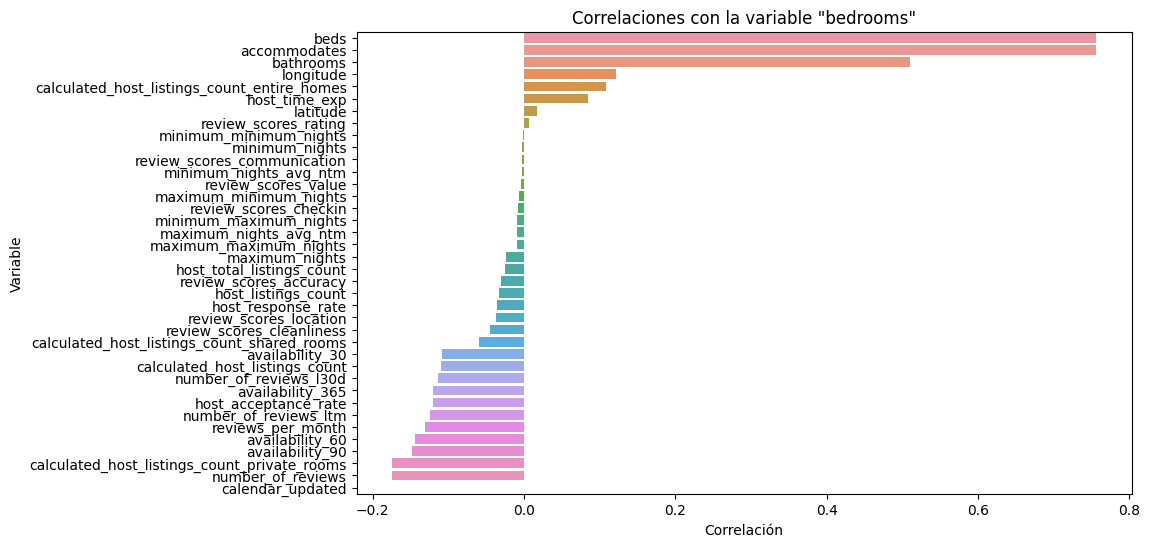

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las correlaciones con la variable "bedrooms"
correlations = df.corr()['bedrooms'].sort_values(ascending=False)

# Eliminar la correlación de "bedrooms" consigo misma
correlations = correlations.drop('bedrooms')

# Graficar las correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.title('Correlaciones con la variable "bedrooms"')
plt.show()


usaremos "beds//bathrooms//accommodates" para imputar, variables que logicamente estan relacionadas con la cantidad de dormitorios.

In [224]:
import pandas as pd
import numpy as np

# Paso 1: Filtrar filas con valores faltantes en "bedrooms"
missing_bedrooms = df[df['bedrooms'].isnull()]

# Paso 2: Iterar sobre las filas faltantes y buscar valores similares en las otras variables
for index, row in missing_bedrooms.iterrows():
    beds = row['beds']
    bathrooms = row['bathrooms']
    accommodates = row['accommodates']
    
    # Paso 3: Filtrar filas con valores similares en las otras variables
    similar_rows = df[(df['beds'] == beds) & (df['bathrooms'] == bathrooms) & (df['accommodates'] == accommodates)]
    
    # Paso 4: Imputar el valor mediano de "bedrooms" de las filas similares
    median_bedrooms = similar_rows['bedrooms'].median()
    df.loc[index, 'bedrooms'] = median_bedrooms

#quedan algunos sin imputar asiq lo hacemos con la moda = mediana 

# Calcular la moda general de la variable "bedrooms"
mode_bedrooms = df['bedrooms'].mode()[0]

# Imputar los valores faltantes con la moda general
df['bedrooms'].fillna(mode_bedrooms, inplace=True)

df['bedrooms'].isna().sum()



/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0



*   beds (70) --> imputamos en relacion a bathrooms bedrooms y accommodates



hacemos un test de correlacion de beds con otras variables para saber con cuales es logico imputar

<ipython-input-225-85574376f760>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['beds'].sort_values(ascending=False)


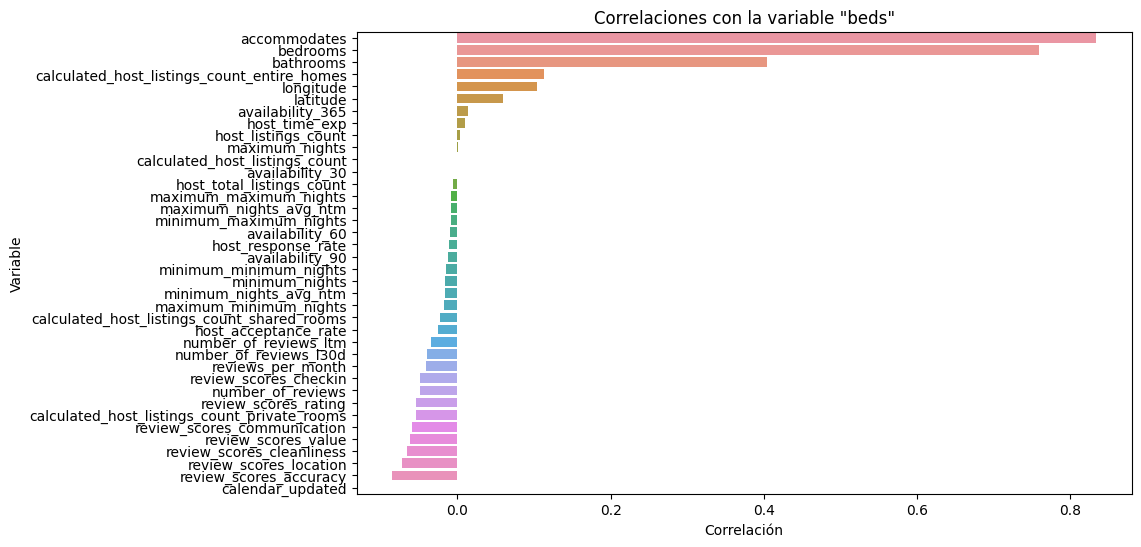

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las correlaciones con la variable "bedrooms"
correlations = df.corr()['beds'].sort_values(ascending=False)

# Eliminar la correlación de "beds" consigo misma
correlations = correlations.drop('beds')

# Graficar las correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.title('Correlaciones con la variable "beds"')
plt.show()

usamos entonces bedrooms//bathrooms//accommodates para imputar

In [226]:
import pandas as pd
import numpy as np

# Paso 1: Filtrar filas con valores faltantes en "bedrooms"
missing_bedrooms = df[df['beds'].isnull()]

# Paso 2: Iterar sobre las filas faltantes y buscar valores similares en las otras variables
for index, row in missing_bedrooms.iterrows():
    bedrooms = row['bedrooms']
    bathrooms = row['bathrooms']
    accommodates = row['accommodates']
    
    # Paso 3: Filtrar filas con valores similares en las otras variables
    similar_rows = df[(df['bedrooms'] == bedrooms) & (df['bathrooms'] == bathrooms) & (df['accommodates'] == accommodates)]
    
    # Paso 4: Imputar el valor mediano de "beds" de las filas similares
    median_bedrooms = similar_rows['beds'].median()
    df.loc[index, 'beds'] = median_bedrooms

#quedan algunos sin imputar asiq lo hacemos con la moda = mediana 

# Calcular la moda general de la variable "beds"
mode_bedrooms = df['beds'].mode()[0]

# Imputar los valores faltantes con la moda general
df['beds'].fillna(mode_bedrooms, inplace=True)

df['beds'].isna().sum()

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0

hay 4 filas que tienen missing en las siguientes variables:

review_scores_accuracy

review_scores_cleanliness

review_scores_checkin

review_scores_communication

review_scores_location

review_scores_value

***se descartan de la base.***

In [227]:
df.dropna(subset=['review_scores_cleanliness'], inplace=True)


todos los campos de calendar_updated son missings, descartamos por ahora la variable 

In [228]:
df.drop('calendar_updated', axis=1, inplace=True)


**Asi queda el df sin datos nulos ni missings**

In [229]:
print("datos nulos: ")
print(df.isnull().sum().sum())


datos nulos: 
0


### Outliers

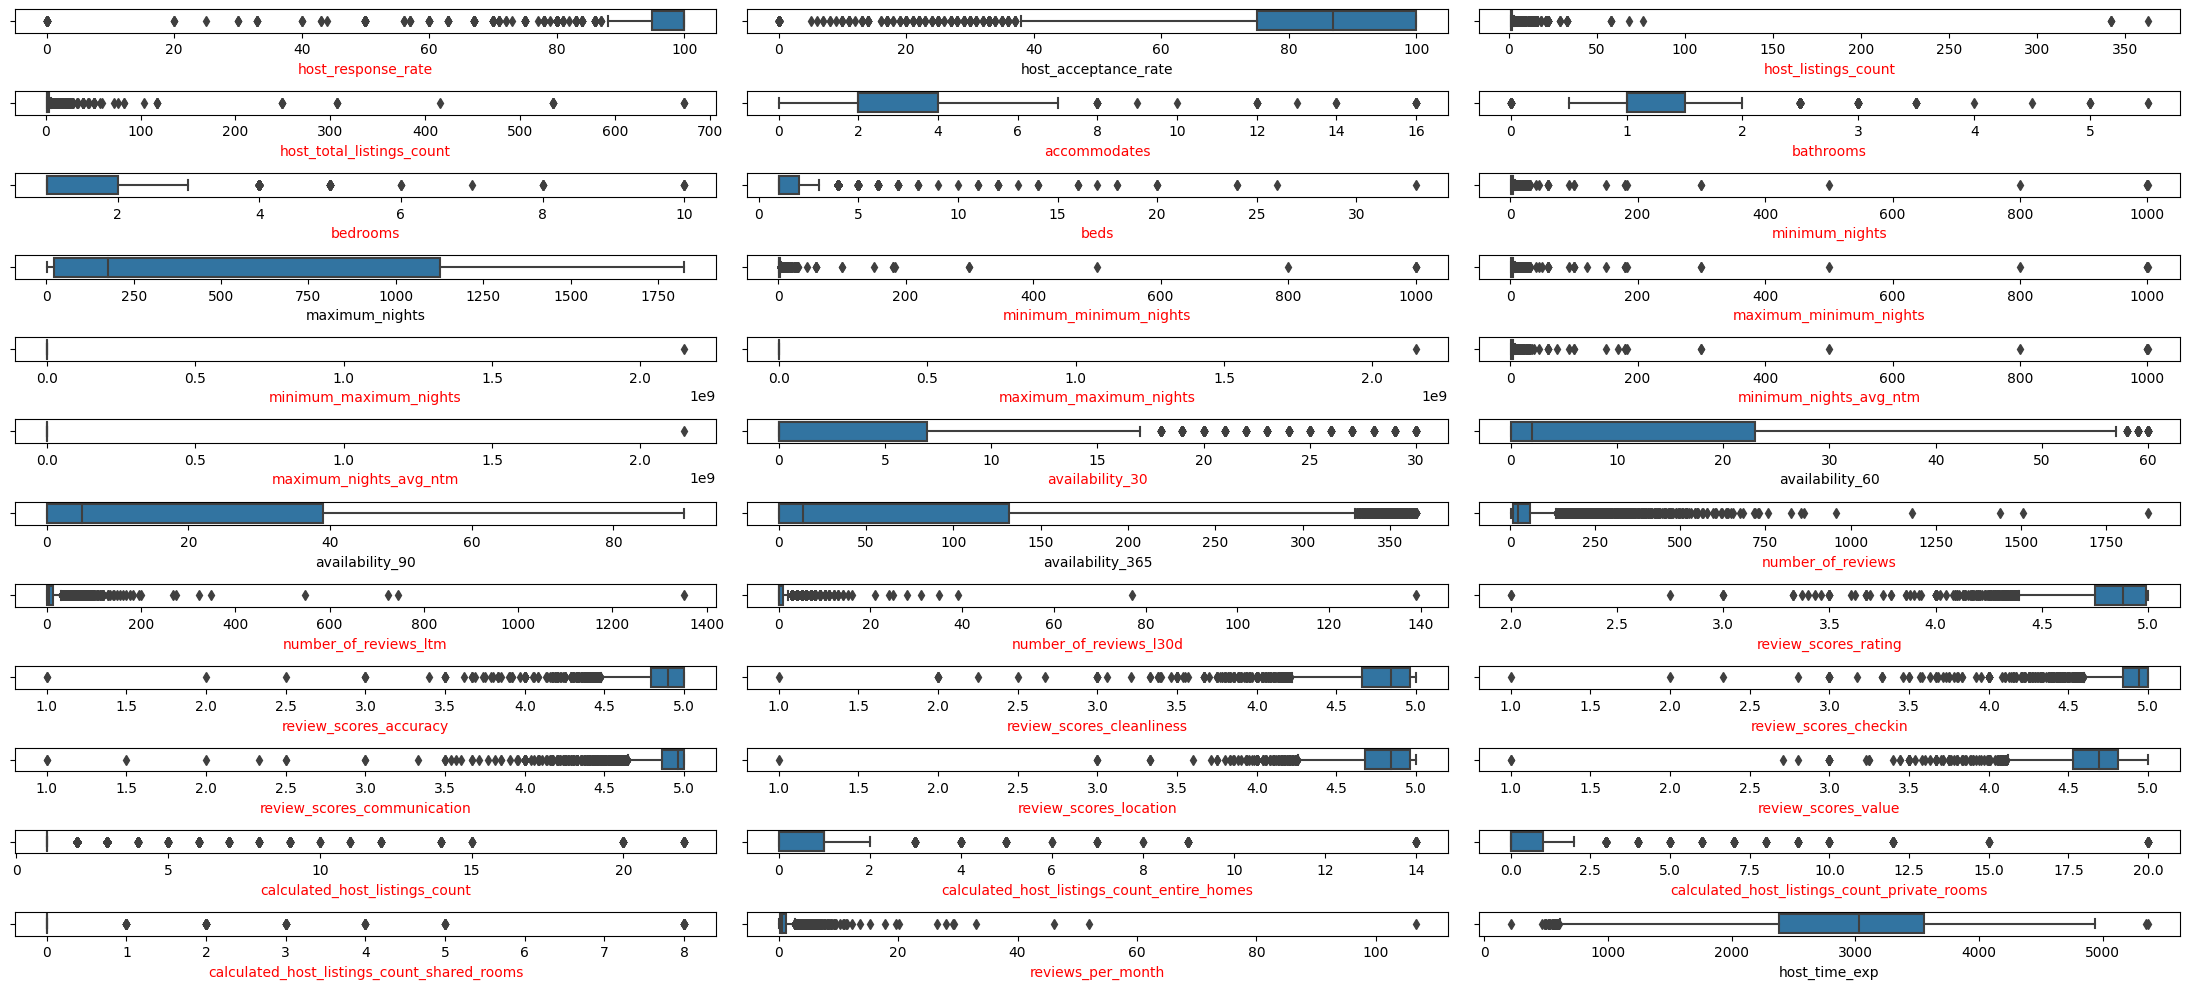

In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'df' con todas tus variables

# Filtra solo las columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Elimina las variables 'longitude' y 'latitude' de la lista de columnas numéricas
numeric_columns = numeric_columns.drop(['longitude', 'latitude'])

# Calcula el número de filas y columnas para el subplot
n_rows = int(np.ceil(len(numeric_columns) / 3))
n_cols = 3

# Crea el subplot con el tamaño deseado
fig, axs = plt.subplots(n_rows, n_cols, figsize=(22, 10))

# Itera sobre cada columna numérica y crea un boxplot en el subplot correspondiente
for i, column in enumerate(numeric_columns):
    row = i // n_cols
    col = i % n_cols
    
    # Crea el boxplot para la columna actual
    sns.boxplot(x=df[column], ax=axs[row, col])
    axs[row, col].set_xlabel(column)
    
    # Verifica si hay outliers en la columna actual
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    has_outliers = any((df[column] < lower_bound) | (df[column] > upper_bound))
    
    # Si hay outliers, cambia el color del título a rojo
    if has_outliers:
        axs[row, col].set_xlabel(column, color='red')
    
# Elimina los subplots vacíos si hay menos variables que subplots
if len(numeric_columns) < n_rows * n_cols:
    for i in range(len(numeric_columns), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axs[row, col])

# Ajusta el espaciado entre los subplots
fig.tight_layout()

# Muestra el gráfico de cajas
plt.show()



A simple vista se ven algunos outliers en varias variables pero ninguno parece representar un valor imposible o poco probable, se tiene en cuenta que debe haber hosts de airbnb con muchos rentas distintas muy grandes que van a destacar por sobre otros que posean una sola propiedad.

*    host listings count 

In [231]:
df[df['host_listings_count']>100].sort_values(by='host_listings_count',ascending=False).head(20)




,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp
2329,22872252,city scrape,Apartment on great location in the centre of A...,This is a beautiful 2-bedroom apartment in the...,none,121985032,Tess - BELVILLA,2017-03-22,"Zürich, Switzerland","Hi, I’m Tess. I’m part of the Belvilla Custome...",within an hour,100.0,97.0,f,unknown,363,416,"['email', 'phone']",t,t,unknown,Centrum-West,52.36882,4.88213,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,3.0,"[""Private entrance"", ""Hangers"", ""Wifi"", ""Kitch...",$465.00,1,28,1,3,3,28,2.2,24.8,t,10,36,66,335,2022-12-05,39,21,1,2018-09-17,2022-11-13,4.71,4.76,4.50,4.79,4.84,5.00,4.58,Exempt,t,1,1,0,0,0.76,2268
1045,9816257,city scrape,Houseboat studio with canal view and bikes,Private studioroom on a houseboat with a stunn...,Amsterdam is one of the greatest small cities ...,517215,Rental Valley,2011-04-18,"Amsterdam, Netherlands","Hi,\n\nMeet our Rental Valley team, we host th...",within an hour,100.0,93.0,f,Oud-Zuid,342,673,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Zuid,52.33878,4.84729,Private room in bed and breakfast,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Kitchen"", ""Wifi...",$100.00,2,1125,2,3,30,1125,3.0,32.5,t,2,9,13,142,2022-12-05,82,9,1,2016-01-02,2022-11-08,4.87,4.91,4.97,4.99,4.94,4.66,4.68,0363 904F 6149 1902 8FAF,t,3,0,3,0,0.97,4433
1052,9903960,city scrape,Classy Room 17th Century Canal House,Private double room in a canal house dating fr...,"In my neighbourhood, there are lots of things ...",517215,Rental Valley,2011-04-18,"Amsterdam, Netherlands","Hi,\n\nMeet our Rental Valley team, we host th...",within an hour,100.0,93.0,f,Oud-Zuid,342,673,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Centrum-West,52.37796,4.89173,Private room in townhouse,Private room,2,1.0,1 private bath,1.0,1.0,"[""Crib"", ""Smoke alarm"", ""Fire extinguisher"", ""...",$166.00,1,1125,1,2,30,30,1.7,30.0,t,2,7,15,118,2022-12-05,520,64,1,2015-12-31,2022-11-08,4.90,4.93,4.94,4.92,4.92,4.98,4.75,0363 3223 E976 5314 BBB1,t,3,0,3,0,6.16,4433
4577,51572428,city scrape,Bb 1971 Hazenstraat shared bathroom,This cozy private room witch shared bathroom s...,The apartment is in the heart of Amsterdam cen...,517215,Rental Valley,2011-04-18,"Amsterdam, Netherlands","Hi,\n\nMeet our Rental Valley team, we host th...",within an hour,100.0,93.0,f,Oud-Zuid,342,673,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Centrum-West,52.36912,4.88000,Private room in home,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Coffee maker"", ...",$140.00,2,1125,2,22,1125,1125,13.1,1125.0,t,9,22,32,274,2022-12-05,27,17,0,2021-08-20,2022-09-29,4.59,4.44,4.30,4.74,4.74,5.00,4.48,0363 6876 27B5 F4AD 09D8,t,3,0,3,0,1.71,4433


In [232]:
#df = df.drop(df[df['host_listings_count']>100].index)

no parecen ser casos irreales, pero si pueden complicar el modelo, por lo que se eliminan algunos valores extremos

*    host total listings count

In [233]:
df[df['host_total_listings_count']>400].sort_values(by='host_total_listings_count',ascending=False).head(20)


,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp
1045,9816257,city scrape,Houseboat studio with canal view and bikes,Private studioroom on a houseboat with a stunn...,Amsterdam is one of the greatest small cities ...,517215,Rental Valley,2011-04-18,"Amsterdam, Netherlands","Hi,\n\nMeet our Rental Valley team, we host th...",within an hour,100.0,93.0,f,Oud-Zuid,342,673,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Zuid,52.338780,4.847290,Private room in bed and breakfast,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Kitchen"", ""Wifi...",$100.00,2,1125,2,3,30,1125,3.0,32.5,t,2,9,13,142,2022-12-05,82,9,1,2016-01-02,2022-11-08,4.87,4.91,4.97,4.99,4.94,4.66,4.68,0363 904F 6149 1902 8FAF,t,3,0,3,0,0.97,4433
1052,9903960,city scrape,Classy Room 17th Century Canal House,Private double room in a canal house dating fr...,"In my neighbourhood, there are lots of things ...",517215,Rental Valley,2011-04-18,"Amsterdam, Netherlands","Hi,\n\nMeet our Rental Valley team, we host th...",within an hour,100.0,93.0,f,Oud-Zuid,342,673,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Centrum-West,52.377960,4.891730,Private room in townhouse,Private room,2,1.0,1 private bath,1.0,1.0,"[""Crib"", ""Smoke alarm"", ""Fire extinguisher"", ""...",$166.00,1,1125,1,2,30,30,1.7,30.0,t,2,7,15,118,2022-12-05,520,64,1,2015-12-31,2022-11-08,4.90,4.93,4.94,4.92,4.92,4.98,4.75,0363 3223 E976 5314 BBB1,t,3,0,3,0,6.16,4433
4577,51572428,city scrape,Bb 1971 Hazenstraat shared bathroom,This cozy private room witch shared bathroom s...,The apartment is in the heart of Amsterdam cen...,517215,Rental Valley,2011-04-18,"Amsterdam, Netherlands","Hi,\n\nMeet our Rental Valley team, we host th...",within an hour,100.0,93.0,f,Oud-Zuid,342,673,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Centrum-West,52.369120,4.880000,Private room in home,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Coffee maker"", ...",$140.00,2,1125,2,22,1125,1125,13.1,1125.0,t,9,22,32,274,2022-12-05,27,17,0,2021-08-20,2022-09-29,4.59,4.44,4.30,4.74,4.74,5.00,4.48,0363 6876 27B5 F4AD 09D8,t,3,0,3,0,1.71,4433
1024,9536529,city scrape,Chic & Cosy B&B near the RAI!,Enjoy your stay in Amsterdam like a true local...,The apartment is located just outside the city...,1464510,Wendy And Bram,2011-12-02,"Amsterdam, Netherlands","Hi, we are Wendy and Bram,\n\nWe are a team of...",within an hour,86.0,90.0,f,Bos en Lommer,7,535,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",De Pijp - Rivierenbuurt,52.341003,4.903122,Private room in bed and breakfast,Private room,4,1.0,1 bath,2.0,2.0,"[""Smoke alarm"", ""Fire extinguisher"", ""Dedicate...",$187.00,2,365,3,5,365,365,4.4,365.0,t,0,0,0,0,2022-12-05,43,21,0,2016-01-03,2022-08-08,4.35,4.49,4.37,4.29,4.38,4.19

In [234]:
#df = df.drop(df[df['host_total_listings_count']>400].index)

*   number_of_reviews


In [235]:
df[df['number_of_reviews']>1000].sort_values(by='number_of_reviews',ascending=False).head(20)


,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp
4407,50383849,city scrape,Citiez Hotel Amsterdam: Small Double Room,Ons stijlvolle hotel biedt kamers die elk een ...,"Sloterpark, bars & restaurants, winkelcentrum ...",407017762,Jean Paul,2021-06-14,"Amsterdam, Netherlands",none,within an hour,99.0,100.0,f,unknown,5,5,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Osdorp,52.35831,4.80335,Room in hotel,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Fire extinguisher"", ""Conditio...",$97.00,1,365,1,3,12,12,1.0,12.0,t,21,51,81,356,2022-12-05,1875,1352,139,2021-06-27,2022-12-05,4.66,4.72,4.67,4.89,4.84,4.32,4.48,Exempt,t,5,0,5,0,106.74,723
3081,32485135,city scrape,Sleep in a Hub!,CityHub is a urban hotel for the new generatio...,CityHub Amsterdam is located right next to the...,243087395,CityHub,2019-02-14,"Amsterdam, Netherlands",none,within an hour,100.0,100.0,t,Oud-West,1,2,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",De Baarsjes - Oud-West,52.36798,4.86633,Room in hotel,Hotel room,2,0.0,unknown,1.0,1.0,"[""Smoke alarm"", ""Fire extinguisher"", ""Luggage ...",$112.00,1,1125,1,3,1000,1000,1.2,1000.0,t,28,57,87,362,2022-12-05,1507,744,77,2019-03-12,2022-12-04,4.84,4.88,4.79,4.91,4.91,4.68,4.60,Exempt,t,1,0,0,0,33.12,1574
4056,45045046,city scrape,Eco-friendly Double Room by Vondelpark,<b>The space</b><br />At The Tire Station we t...,Conscious Hotel The Tire Station is located ri...,363404652,Conscious Hotel The Tire Station,2020-08-20,"Amsterdam, Netherlands",We are conscious about the choices we make. Th...,within an hour,98.0,100.0,f,unknown,4,4,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",De Baarsjes - Oud-West,52.35815,4.85627,Room in boutique hotel,Private room,2,1.0,1 bath,1.0,1.0,"[""Smoke alarm"", ""Hangers"", ""Wifi"", ""Long term ...",$116.00,1,365,1,2,365,999,1.2,733.7,t,26,56,86,340,2022-12-05,1440,724,31,2020-08-27,2022-11-21,4.72,4.79,4.75,4.77,4.73,4.57,4.57,Exempt,t,4,0,4,0,51.99,1021
3344,35927687,city scrape,Generator - Bed in 4 bed Dorm,Generator Amsterdam is a design hotel-hostel l...,Generator Amsterdam is perfectly placed betwee...,251479377,Generator,2019-03-27,"Amsterdam, Netherlands",Generator Amsterdam is located in the up-and-c...,within an hour,97.0,99.0,f,Oosterparkbuurt,6,7,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Oud-Oost,52.36054,4.91984,Shared room in hostel,Shared room,1,1.0,1 shared bath,1.0,2.0,"[""Ping pong table"", ""Board games"", ""Hangers"", ...",$34.00,1,1125,1,3,999,999,1.2,999.0,t,30,60,90,300,2022-12-05,1180,323,24,2019-06-22,2022-11-21,4.50,4.68,4.54,4.68,4.59,4.57,4.47,Exempt,t,6,0,2,3,28.03,1533


In [236]:
#df = df.drop(df[df['number_of_reviews']>1000].index)

*   number of reviews ltm
*   number of reviews l30d

---
con el ajuste de la var anterior se fueron los extremos


In [237]:
df[df['number_of_reviews_l30d']>50].sort_values(by='number_of_reviews_ltm',ascending=False).head(20)


,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp
4407,50383849,city scrape,Citiez Hotel Amsterdam: Small Double Room,Ons stijlvolle hotel biedt kamers die elk een ...,"Sloterpark, bars & restaurants, winkelcentrum ...",407017762,Jean Paul,2021-06-14,"Amsterdam, Netherlands",none,within an hour,99.0,100.0,f,unknown,5,5,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Osdorp,52.35831,4.80335,Room in hotel,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Fire extinguisher"", ""Conditio...",$97.00,1,365,1,3,12,12,1.0,12.0,t,21,51,81,356,2022-12-05,1875,1352,139,2021-06-27,2022-12-05,4.66,4.72,4.67,4.89,4.84,4.32,4.48,Exempt,t,5,0,5,0,106.74,723
3081,32485135,city scrape,Sleep in a Hub!,CityHub is a urban hotel for the new generatio...,CityHub Amsterdam is located right next to the...,243087395,CityHub,2019-02-14,"Amsterdam, Netherlands",none,within an hour,100.0,100.0,t,Oud-West,1,2,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",De Baarsjes - Oud-West,52.36798,4.86633,Room in hotel,Hotel room,2,0.0,unknown,1.0,1.0,"[""Smoke alarm"", ""Fire extinguisher"", ""Luggage ...",$112.00,1,1125,1,3,1000,1000,1.2,1000.0,t,28,57,87,362,2022-12-05,1507,744,77,2019-03-12,2022-12-04,4.84,4.88,4.79,4.91,4.91,4.68,4.60,Exempt,t,1,0,0,0,33.12,1574


*    minimum nights

In [238]:
df[df['minimum_nights']>200]

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp
220,1914964,city scrape,17th Century Monumental House with Garden,Please be very welcome in our 17th century hou...,"It's situated on Realeneiland, a little island...",8982547,Martine,2013-09-22,"Amsterdam, Netherlands","We are a a family of four. Olivier (the dad), ...",unknown,95.475502,80.490848,f,Westelijke Eilanden,2,2,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Centrum-West,52.38659,4.88950,Entire home,Entire home/apt,6,2.0,2 baths,3.0,3.0,"[""Smoke alarm"", ""Lockbox"", ""Hangers"", ""Wifi"", ...",$600.00,300,300,300,300,300,300,300.0,300.0,t,29,59,89,364,2022-12-05,28,0,0,2014-01-04,2017-09-24,5.00,4.93,4.89,5.00,5.00,4.89,4.79,0363 7C32 C932 83D2 F5D8,f,2,1,1,0,0.26,3545
851,7394725,previous scrape,Light apartment - quiet neighbourh.,"A great apartment in a quiet neighbourhood, wi...",none,1930105,Roel,2012-03-15,"Amsterdam, Netherlands",I'am working as a consultant for a small compa...,unknown,95.834731,0.000000,f,Bos en Lommer,1,2,"['email', 'phone']",t,t,unknown,Bos en Lommer,52.37928,4.85735,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Smoke alarm"", ""Fire extinguisher"", ""TV"", ""Di...",$131.00,800,1125,800,800,1125,1125,800.0,1125.0,t,25,50,77,352,2022-12-05,41,0,0,2015-09-15,2021-11-09,4.77,4.92,4.85,4.92,4.85,4.67,4.66,0363 ED9D D582 73F0 0D4D,f,1,1,0,0,0.47,4101
1859,18471773,previous scrape,★ DUPLEX APARTMENT ★ AMSTERDAM ★ NDSM WARF ★,The bright living room of this duplex apartmen...,Amsterdam Noord is the new place to be! Lot's ...,46691672,Eva & Kobe,2015-10-16,"Amsterdam, Netherlands",Hi! We are Eva & Kobe! \n\nYou’re more than we...,unknown,94.988347,100.000000,t,Weesperbuurt en Plantage,58,249,"['email', 'phone', 'work_email']",t,t,"Amsterdam, Noord-Holland, Netherlands",Oud-Noord,52.39974,4.90415,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Smoke alarm"", ""Pocket wifi"", ""Paid parking o...",$127.00,1000,1001,1000,1000,1001,1001,1000.0,1001.0,t,0,0,0,0,2022-12-05,19,2,0,2017-05-08,2022-04-24,4.79,4.89,4.84,4.95,4.95,4.53,4.63,0363 5F75 487F 8C50 AF40,f,9,8,1,0,0.28,2791
1909,18816109,previous scrape,Nice room,Welcome to my cool and comfortable room with a...,none,21681343,Raffaele,2014-09-23,"Milan, Italy",none,unknown,95.239032,80.490848,f,De Pijp,2,4,"['email', 'phone']",t,t,unknown,De Pijp - Rivierenbuurt,52.35183,4.89873,Private room in rental unit,Private room,4,1.0,1 shared bath,2.0,1.0,"[""Kitchen"", ""Wifi"", ""Long term stays allowed"",...",$121.00,1001,1125,1001,1001,1125,1125,1001.0,1125.0,t,29,59,89,89,2022-12-05,24,0,0,2017-09-18,2018-11-25,4.58,4.63,4.21,4.96,5.00,4.67,4.46,0363 80E2 0920 0E13 6E13,f,2,1,1,0,0.38,3179
1953,19183967,previous scrape,Private cosy place with 24/7 access. And 4 bikes,It's a petite place. In a nice quiet area of t...,"It's situate

In [239]:
#df = df.drop(df[df['minimum_nights']>200].index)

*    minimum maximum nights

> se encontro que hay unicamente dos valores por encima de 1125, pero mas de dosmil que son =1125, por el momento eliminamos los dos extremos 



In [240]:
df[df['minimum_maximum_nights']>1125]

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp
4,28871,city scrape,Comfortable double room,<b>The space</b><br />In a monumental house ri...,"Flower market , Leidseplein , Rembrantsplein",124245,Edwin,2010-05-13,"Amsterdam, Netherlands",Hi,within a few hours,100.0,100.0,t,Amsterdam Centrum,2,2,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Centrum-West,52.36775,4.89092,Private room in rental unit,Private room,2,1.0,1 shared bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Lock on bedroom...",$75.00,2,1825,2,2,1825,1825,2.0,1.825000e+03,t,0,3,8,91,2022-12-05,454,84,7,2010-08-22,2022-11-20,4.88,4.93,4.89,4.95,4.94,4.97,4.83,0363 607B EA74 0BD8 2F6F,f,2,0,2,0,3.03,4773
3619,39529278,city scrape,"Hoxton Amsterdam, Cosy Room",Set in a series of 5 classic brick canal house...,none,303597180,Hoxton Amsterdam,2019-10-21,"Amsterdam, Netherlands",none,within an hour,86.0,100.0,f,Grachtengordel,2,2,"['email', 'phone', 'work_email']",t,t,unknown,Centrum-West,52.37154,4.88654,Room in boutique hotel,Private room,2,1.0,1 bath,1.0,1.0,"[""Smoke alarm"", ""Private entrance"", ""Hangers"",...",$308.00,1,1125,1,4,2147483647,2147483647,1.2,2.147484e+09,t,25,55,85,260,2022-12-05,9,6,1,2020-01-27,2022-11-11,4.56,5.00,5.00,4.44,4.67,5.00,4.33,Exempt,t,2,0,2,0,0.26,1325


In [241]:
#df = df.drop(df[df['minimum_maximum_nights']>1125].index)

### Target y correlaciones    

*    review_scores_rating

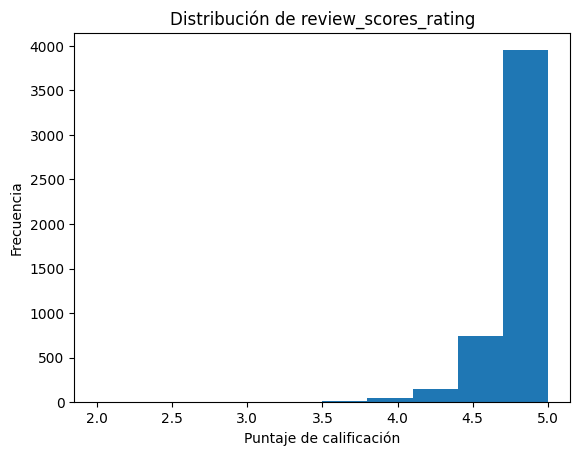

In [242]:

plt.hist(df['review_scores_rating'], bins=10)
plt.xlabel('Puntaje de calificación')
plt.ylabel('Frecuencia')
plt.title('Distribución de review_scores_rating')
plt.show()

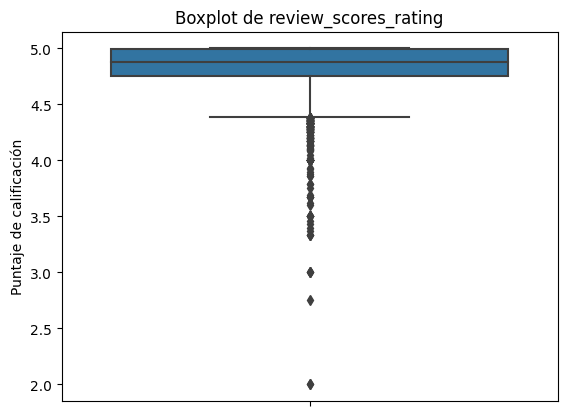

In [243]:
sns.boxplot(data=df, y='review_scores_rating')
plt.ylabel('Puntaje de calificación')
plt.title('Boxplot de review_scores_rating')
plt.show()


In [244]:
stats = df['review_scores_rating'].describe()

print(stats)

count    4924.000000
mean        4.816239
std         0.226507
min         2.000000
25%         4.750000
50%         4.880000
75%         4.990000
max         5.000000
Name: review_scores_rating, dtype: float64


corr de la target contra otras

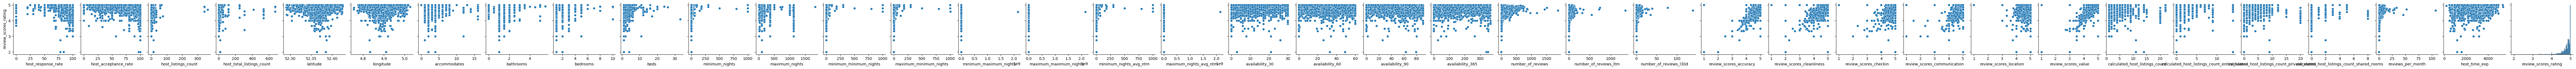

In [245]:
# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Crear el gráfico de dispersión y distribuciones
sns.pairplot(numeric_df, y_vars='review_scores_rating')

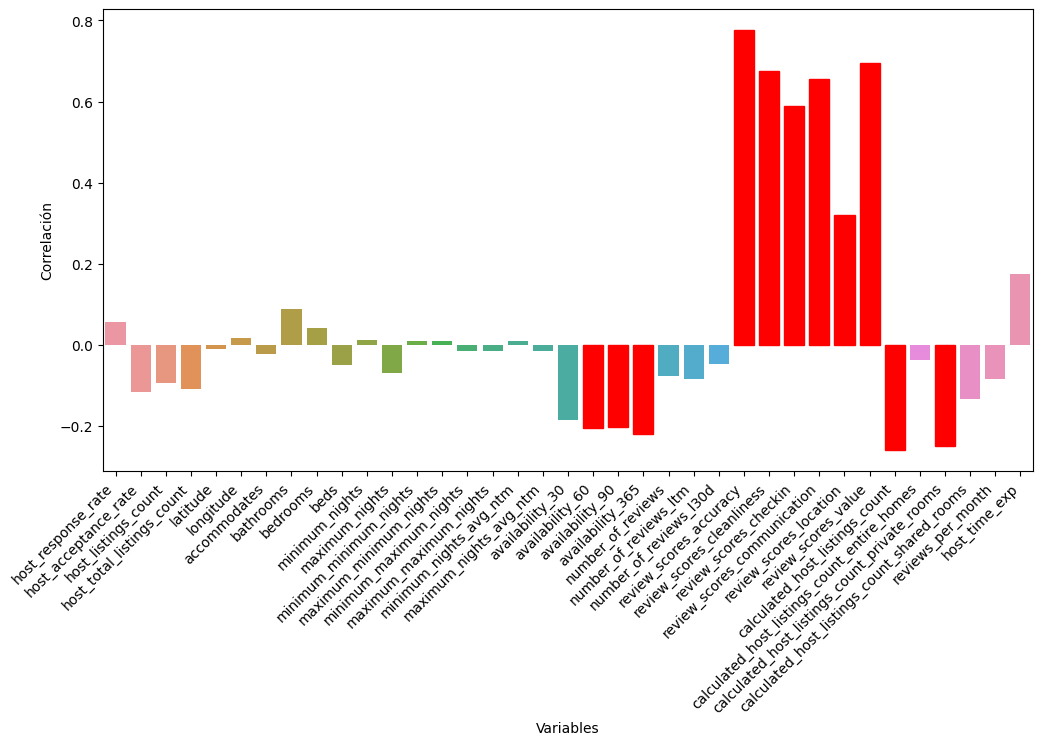

In [246]:


# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Calcular la correlación entre "review_scores_rating" y las demás variables numéricas
correlations = numeric_df.corr()['review_scores_rating']

# Eliminar la correlación consigo misma (valor de 1)
correlations = correlations.drop('review_scores_rating')

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Generar el gráfico de barras
barplot = sns.barplot(x=correlations.index, y=correlations.values, ax=ax)

# Establecer los nombres de las variables en el eje x
ax.set_xticklabels(correlations.index, rotation=45, ha='right')

# Etiquetas de los ejes
ax.set_xlabel('Variables')
ax.set_ylabel('Correlación')

# Modificar el color de las etiquetas de las variables según la correlación
for i, bar in enumerate(barplot.patches):
    if correlations[i] > 0.2 or correlations[i] < -0.2:
        bar.set_color('red')

# Mostrar el gráfico
plt.show()


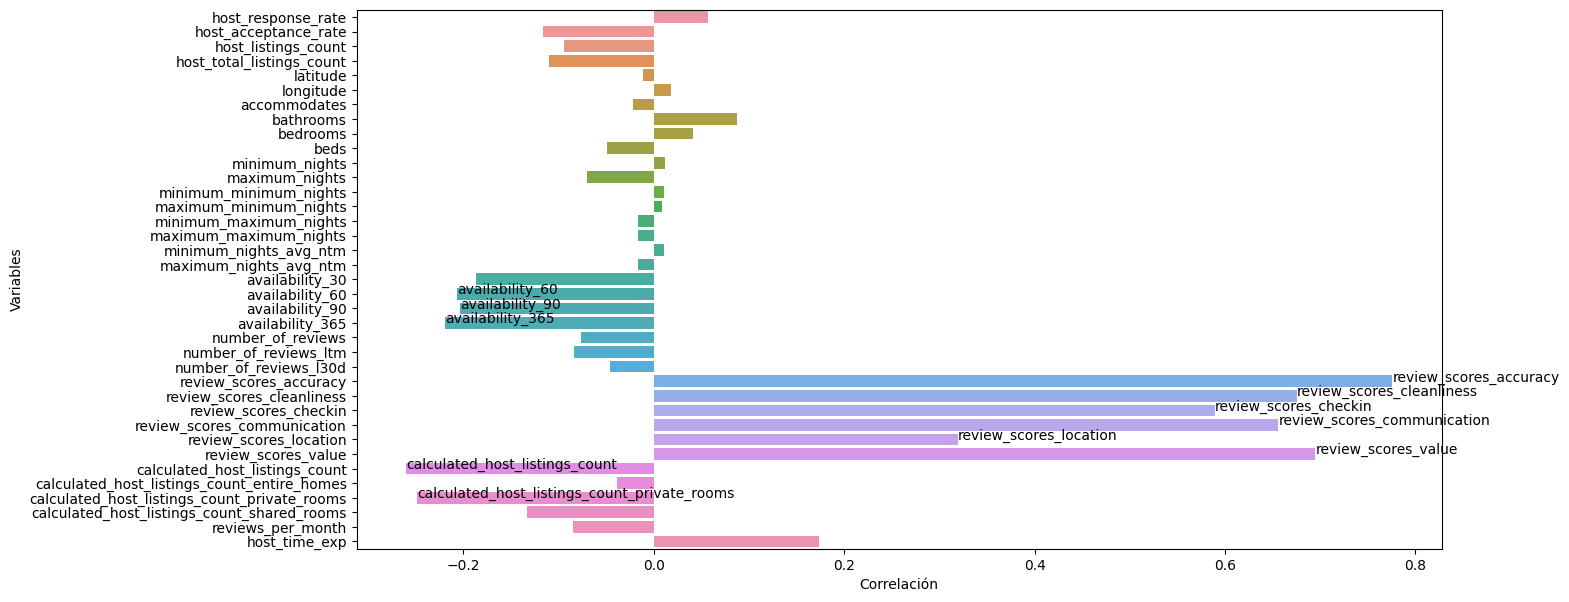

In [247]:

# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Calcular la correlación entre "review_scores_rating" y las demás variables numéricas
correlations = numeric_df.corr()['review_scores_rating']

# Eliminar la correlación consigo misma (valor de 1)
correlations = correlations.drop('review_scores_rating')

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(14, 7))

# Generar el gráfico de barras
barplot = sns.barplot(x=correlations.values, y=correlations.index, ax=ax)

# Modificar el color del label de la variable según la correlación
for i, bar in enumerate(barplot.patches):
    if correlations[i] > 0.2 or correlations[i] < -0.2:
        barplot.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, correlations.index[i], ha='left', color='black')

# Etiquetas de los ejes
ax.set_xlabel('Correlación')
ax.set_ylabel('Variables')

# Mostrar el gráfico
plt.show()


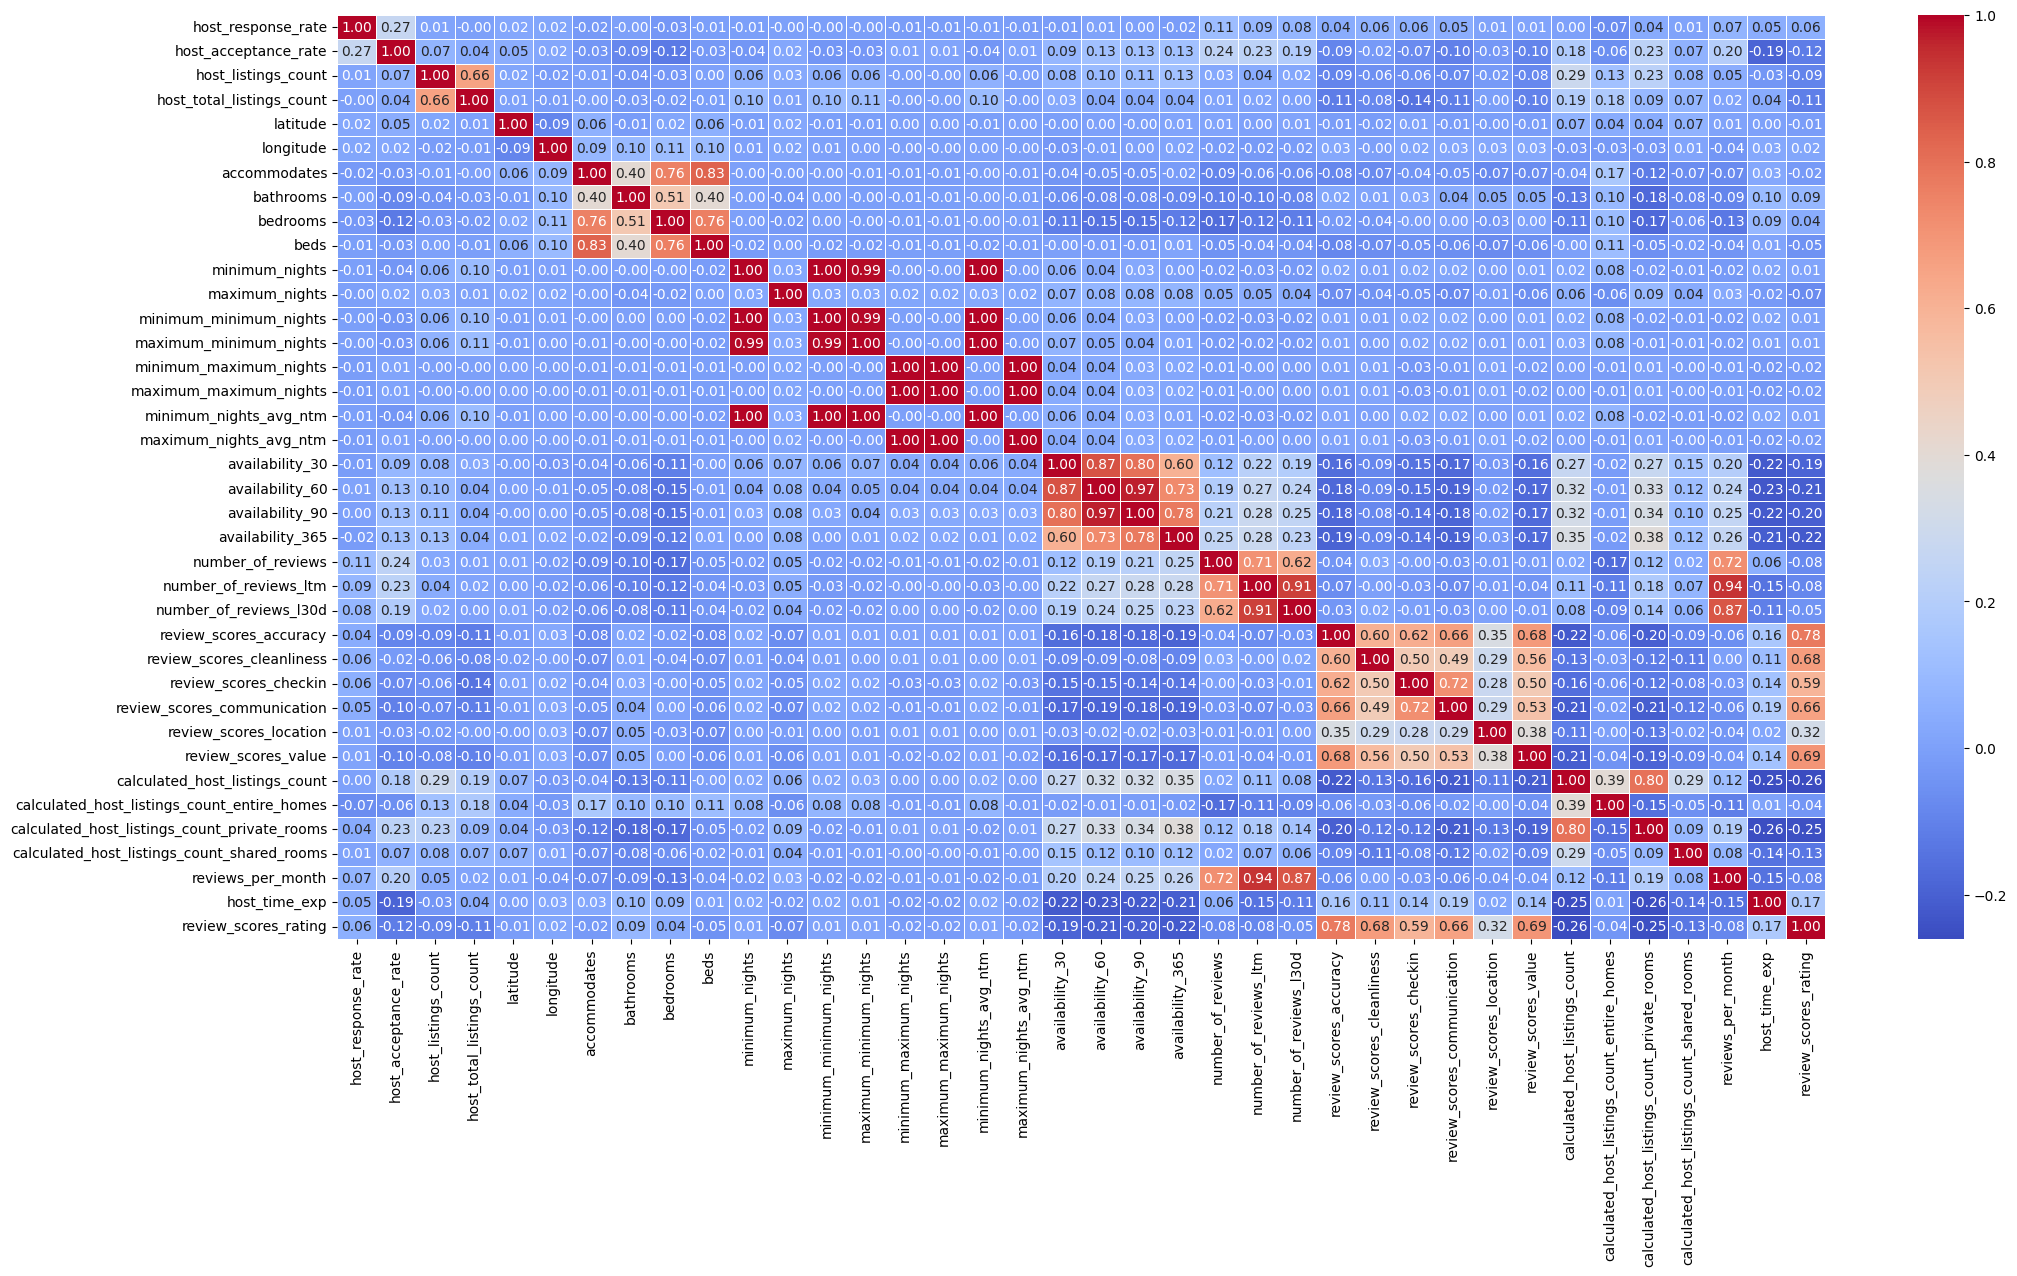

In [248]:
# Seleccionar las columnas numéricas, excluyendo "review_scores_rating"
numeric_columns = df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('review_scores_rating')

# Crear un nuevo DataFrame solo con las columnas numéricas
numeric_df = df[numeric_columns + ['review_scores_rating']].copy()

# Eliminar las filas con valores faltantes
numeric_df.dropna(inplace=True)

# Calcular la matriz de correlaciones
correlation_matrix = numeric_df.corr()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(24, 12))

# Generar la matriz de correlaciones gráfica
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax)

# Mostrar el gráfico
plt.show()

### Creacion de Variables



*   Creamos host_country y host_city_or_state a partir de la host_location



In [249]:
host_location_counts = df['host_location'].value_counts()
print(host_location_counts.to_string())


Amsterdam, Netherlands                  4625
Netherlands                              133
Amstelveen, Netherlands                    8
Haarlem, Netherlands                       7
London, United Kingdom                     7
Nederland, CO                              6
Utrecht, Netherlands                       6
The Hague, Netherlands                     5
New York, NY                               5
Nieuwegein, Netherlands                    4
Bogotá, Colombia                           3
Huizen, Netherlands                        3
Groningen, Netherlands                     3
Leiden, Netherlands                        3
Bussum, Netherlands                        2
De Pijp, Netherlands                       2
Katwoude, Netherlands                      2
Sydney, Australia                          2
Paris, France                              2
Dublin, Ireland                            2
Bergen, Netherlands                        2
Enkhuizen, Netherlands                     2
Berlin, Ge

In [250]:
def process_host_location(location):
    if ',' in location:
        city, country = location.split(',')
        if country.strip() in ['DC', 'IL', 'CA', 'RI', 'FL', 'CO', 'NY']:
            country = 'United States'
        return city.strip(), country.strip()
    else:
        return location.strip(), ''


df[['host_city_or_state', 'host_country']] = df['host_location'].apply(process_host_location).apply(pd.Series)




*   Creamos la variable price_num


(no cambiamos la categorica ya que quizas le demos uso a futuro)



In [251]:
# Remover caracteres no numéricos y convertir a float
df['price_num'] = df['price'].str.replace('[^\d.]', '', regex=True).astype(float)

# Verificar los resultados
print(df[['price', 'price_num']].head(50))

        price  price_num
0     $100.00      100.0
1      $59.00       59.0
2     $106.00      106.0
3     $140.00      140.0
4      $75.00       75.0
5      $55.00       55.0
6     $240.00      240.0
7     $260.00      260.0
8     $127.00      127.0
9     $149.00      149.0
10    $120.00      120.0
11    $113.00      113.0
12    $119.00      119.0
13    $170.00      170.0
14     $61.00       61.0
15    $265.00      265.0
16    $200.00      200.0
17    $145.00      145.0
18    $111.00      111.0
19    $195.00      195.0
20    $120.00      120.0
21    $380.00      380.0
22     $60.00       60.0
23    $220.00      220.0
24    $200.00      200.0
25    $115.00      115.0
26    $300.00      300.0
27    $119.00      119.0
28    $439.00      439.0
29    $132.00      132.0
30    $350.00      350.0
31    $475.00      475.0
32    $164.00      164.0
33     $88.00       88.0
34    $146.00      146.0
35    $300.00      300.0
36    $986.00      986.0
37    $143.00      143.0
38    $146.00      146.0


*   price_num

In [252]:
df[df['price_num']>5000]

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp,host_city_or_state,host_country,price_num
785,6801759,city scrape,Private room in sunny houseboat!,Feel the buzz of the city on a typical Amsterd...,none,1899873,Liz,2012-03-11,"Amsterdam, Netherlands","Hi, my name is Liz. I am a freelance conferenc...",within an hour,100.000000,98.0,t,Oud-West,1,1,"['email', 'phone']",t,t,unknown,De Baarsjes - Oud-West,52.36846,4.87389,Private room in houseboat,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Fire extinguisher"", ""Waterfro...","$26,696.00",3,1125,3,3,1125,1125,3.0,1125.0,t,1,1,1,23,2022-12-05,271,24,3,2015-11-18,2022-11-19,4.82,4.83,4.82,4.91,4.91,4.91,4.76,unknown,f,1,0,1,0,3.16,4105,Amsterdam,Netherlands,26696.0
1126,11090880,city scrape,Light Studio close to the center and well serv...,Light spacious studio with beautiful full leng...,"West Amsterdam is an upcoming , buzzing, young...",57591198,Aldo,2016-02-06,"Haarlem, Netherlands",none,within an hour,100.000000,100.0,f,Oud-West,1,3,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",De Baarsjes - Oud-West,52.37179,4.84972,Private room in rental unit,Private room,4,1.5,1.5 shared baths,1.0,2.0,"[""Smoke alarm"", ""Paid parking off premises"", ""...","$71,536.00",2,31,2,3,1125,1125,2.0,1125.0,t,3,26,56,322,2022-12-05,104,16,0,2016-04-27,2022-10-29,4.49,4.72,4.45,4.82,4.82,4.64,4.36,03630E762AFDDA099816,t,1,0,1,0,1.29,2678,Haarlem,Netherlands,71536.0
3614,39431135,previous scrape,"Concept Villa, Unique in City Center/Jordaan","Uniquely designed house with 2 bedrooms, a sma...","Located in Amsterdam’s Jordaan district, proba...",3884675,Devran,2012-10-16,"Amsterdam, Netherlands","Devran Gozen\nI am a traveller, with a passion...",unknown,95.695821,67.0,t,Westelijke Eilanden,1,3,"['email', 'phone', 'work_email']",t,t,"Amsterdam, NORTH HOLLAND, Netherlands",Centrum-West,52.38264,4.88572,Entire home,Entire home/apt,4,2.5,2.5 baths,3.0,3.0,"[""Smoke alarm"", ""Board games"", ""Backyard"", ""Fi...","$7,900.00",3,1125,3,3,1125,1125,3.0,1125.0,t,0,0,0,0,2022-12-05,18,5,0,2019-10-28,2022-04-16,4.89,4.94,4.72,4.94,5.00,4.94,4.56,0363 4342 F952 E6D8 901F,f,1,1,0,0,0.48,3886,Amsterdam,Netherlands,7900.0


In [253]:
#df = df.drop(df[df['price_num']>5000].index)

*  Creamos host_time_exp que me dice los dias de experiencia que tiene siendo host a partir de la host_since y hoy. 

In [254]:
import datetime

df['host_since'] = pd.to_datetime(df['host_since'])


now = datetime.datetime.now()
df['host_time_exp'] = (now - df['host_since']).dt.days




*   Creamos la variable shared_bathrooms que dice 1 si hay banos compartidos y 0 si son banos privados a partir de bathrooms_text



In [255]:
df['shared_bathrooms'] = df['bathrooms_text'].str.contains('shared', case=False).astype(int)


In [256]:
def count_unique_values_and_top_values(df):
    # Obtener las columnas categóricas
    categorical_columns = df.select_dtypes(include='object').columns.tolist()

    # Crear un diccionario para almacenar los resultados
    result = {}

    # Contar los valores únicos y obtener los 5 valores más comunes en cada columna categórica
    for column in categorical_columns:
        unique_values = df[column].nunique()
        top_values = df[column].value_counts().head(5).index.tolist()
        result[column] = {'unique_values': unique_values, 'top_values': top_values}

    return result

    # Obtener la cantidad de valores únicos en cada columna categórica
result = count_unique_values_and_top_values(df)

# Imprimir los resultados
for column, count in result.items():
    print(f"{column}: {count}")

id: {'unique_values': 4924, 'top_values': ['528022', '35212974', '35332756', '35329748', '35326837']}
source: {'unique_values': 2, 'top_values': ['city scrape', 'previous scrape']}
name: {'unique_values': 4892, 'top_values': ['Residences | 2-Bedrooms | Serviced Apartment', 'Spacious & convenient stay in Amsterdam South', 'Lovely apartment in Amsterdam', 'Residences | 1-Bedrooms | Serviced Apartment', 'Bb 1971 Hazenstraat shared bathroom']}
description: {'unique_values': 4860, 'top_values': ['Museums, thrift shopping, and stroopwafels — your Amsterdam experience begins at Park House. Each room includes a coffee maker, space to work, and an HDMI-equipped television for streaming. To unwind, we love the cozy lounge and calming garden terrace. <br /> <br />In the Oud-Zuid neighborhood, there’s plenty to discover. PC Hooftstraat has luxury and vintage clothing stores. The iconic Rijksmuseum is home to the best of Dutch art. And Vondelpark hosts seasonal outdoor concerts at the Openluchtthea

In [257]:



def count_unique_values(df):
    # Obtener las columnas categóricas
    categorical_columns = df.select_dtypes(include='object').columns.tolist()

    # Crear un diccionario para almacenar los resultados
    unique_values = {}

    # Contar los valores únicos en cada columna categórica
    for column in categorical_columns:
        unique_values[column] = df[column].nunique()

    return unique_values


# Obtener la cantidad de valores únicos en cada columna categórica
result = count_unique_values(df)

# Imprimir los resultados
for column, count in result.items():
    print(f"{column}: {count}")


id: 4924
source: 2
name: 4892
description: 4860
neighborhood_overview: 3278
host_id: 4177
host_name: 2243
host_location: 107
host_about: 2629
host_response_time: 5
host_is_superhost: 2
host_neighbourhood: 54
host_verifications: 6
host_has_profile_pic: 2
host_identity_verified: 2
neighbourhood: 46
neighbourhood_cleansed: 22
property_type: 52
room_type: 4
bathrooms_text: 20
amenities: 4821
price: 478
has_availability: 2
calendar_last_scraped: 2
first_review: 2150
last_review: 868
license: 4076
instant_bookable: 2
host_city_or_state: 106
host_country: 26


*    creamos source_bin variable  1 = 'city scrape' 0 = 'previous scrape'

In [258]:
# Crear la variable source_bin
df['source_bin'] = df['source'].apply(lambda x: 1 if x == 'city scrape' else 0)

# Verificar los resultados
print(df['source_bin'].value_counts())
print(df['source'].value_counts())

1    3040
0    1884
Name: source_bin, dtype: int64
city scrape        3040
previous scrape    1884
Name: source, dtype: int64


*    creamos host_is_superhost_bin 1=t 0=f

In [259]:

# Función personalizada para asignar valores a host_is_superhost_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_is_superhost_bin
df['host_is_superhost_bin'] = df['host_is_superhost'].apply(map_superhost)

# Verificar los resultados
print(df['host_is_superhost_bin'].value_counts())
print(df['host_is_superhost'].value_counts())

0    3755
1    1169
Name: host_is_superhost_bin, dtype: int64
f    3755
t    1169
Name: host_is_superhost, dtype: int64




*   creamos host_has_profile_pic_bin   1=t 0=f



In [260]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_has_profile_pic_bin
df['host_has_profile_pic_bin'] = df['host_has_profile_pic'].apply(map_superhost)

# Verificar los resultados
print(df['host_has_profile_pic_bin'].value_counts())
print(df['host_has_profile_pic'].value_counts())


1    4916
0       8
Name: host_has_profile_pic_bin, dtype: int64
t    4916
f       8
Name: host_has_profile_pic, dtype: int64




*   Elemento de la lista
*   Elemento de la lista



*   creamos host_identity_verified_bin   1=t 0=f



In [261]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_identity_verified_bin
df['host_identity_verified_bin'] = df['host_identity_verified'].apply(map_superhost)

# Verificar los resultados
print(df['host_identity_verified_bin'].value_counts())
print(df['host_identity_verified'].value_counts())


1    4239
0     685
Name: host_identity_verified_bin, dtype: int64
t    4239
f     685
Name: host_identity_verified, dtype: int64




*   creamos has_availability_bin   1=t 0=f



In [262]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable has_availability_bin
df['has_availability_bin'] = df['has_availability'].apply(map_superhost)

# Verificar los resultados
print(df['has_availability_bin'].value_counts())
print(df['has_availability'].value_counts())


1    4907
0      17
Name: has_availability_bin, dtype: int64
t    4907
f      17
Name: has_availability, dtype: int64




*   creamos calendar_last_scraped_bin   1= '2022-12-05'  0= '2022-12-17'



In [263]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['2022-12-05', 'T']:
        return 1
    elif value in ['2022-12-17', 'F']:
        return 0
    else:
        return None

# Crear la variable calendar_last_scraped_bin
df['calendar_last_scraped_bin'] = df['calendar_last_scraped'].apply(map_superhost)

# Verificar los resultados
print(df['calendar_last_scraped_bin'].value_counts())
print(df['calendar_last_scraped'].value_counts())


1    4923
0       1
Name: calendar_last_scraped_bin, dtype: int64
2022-12-05    4923
2022-12-17       1
Name: calendar_last_scraped, dtype: int64




*   creamos instant_bookable_bin   1= t  0= f



In [264]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ["f", 'F']:
        return 0
    else:
        return None

# Crear la variable instant_bookable_bin
df['instant_bookable_bin'] = df['instant_bookable'].apply(map_superhost)

# Verificar los resultados
print(df['instant_bookable_bin'].value_counts())
print(df['instant_bookable'].value_counts())


0    3810
1    1114
Name: instant_bookable_bin, dtype: int64
f    3810
t    1114
Name: instant_bookable, dtype: int64


*  host_verifications          

---
se crearan 3 variables binarias para indicar si se posee o no esa verificacion y 1 variable mas que cuenta la cantidad de verificaciones


In [265]:
df['host_verifications'].unique()

array(["['email', 'phone']", "['email', 'phone', 'work_email']",
       "['phone']", "['phone', 'work_email']", "['email']", '[]'],
      dtype=object)

In [266]:


# Obtener las verificaciones únicas
unique_verifications = ['phone', 'email', 'work_email']

# Crear las columnas binarias
for verification in unique_verifications:
    df[f'has_{verification}'] = 0

# Agregar la columna verification_count
df['verification_count'] = 0

# Función para contar la cantidad de verificaciones
def count_verifications(verifications):
    return len(verifications)

# Recorrer la columna "host_verifications" y establecer los valores de las columnas binarias y verification_count
for i, row in df.iterrows():
    verifications = row['host_verifications']
    df.at[i, 'verification_count'] = count_verifications(verifications)
    for verification in unique_verifications:
        if verification in verifications:
            df.at[i, f'has_{verification}'] = 1


**Frequency Encoding**


---

frequency encoding para los campos en los que se tiene una cantidad de entre 3 y 110 valores posibles.




host_location
host_neighbourhood
neighbourhood
neighbourhood_cleansed
property_type
room_type
bathrooms_text
host_city_or_state
host_country


price_num
shared_bathrooms
host_time_exp
host_country 
host_city_or_state
time_since_first_review
time_since_last_review
time_between_reviews


In [267]:
categorias = df.select_dtypes(include='object').columns.tolist()

result_freq = [categoria for categoria in categorias if 3 <= df[categoria].nunique() <= 110]
print(result_freq)

['host_location', 'host_response_time', 'host_neighbourhood', 'host_verifications', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'host_city_or_state', 'host_country']


In [268]:
# Variables a las que se les aplicará frequency encoding
variables_categoricas = ['host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood',
                         'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text',
                         'host_city_or_state', 'host_country']

# Iterar sobre las variables y aplicar frequency encoding
for variable in variables_categoricas:
    frecuencias = df[variable].value_counts(normalize=True)  # Calcular las frecuencias relativas
    df[f'{variable}_freq_encoded'] = df[variable].map(frecuencias)  # Mapear las frecuencias a cada categoría


In [269]:
#import ast
#from collections import Counter

# Convertir las cadenas de texto en listas de amenities
#df['amenities'] = df['amenities'].apply(ast.literal_eval)

# Obtener una lista plana de todos los amenities
#amenities_list = [amenity for amenities in df['amenities'] for amenity in amenities]

# Contar la cantidad de cada amenitie
#amenities_count = dict(Counter(amenities_list))




In [270]:
import itertools

# Ordenar el diccionario por los valores de mayor a menor
#sorted_dict = dict(sorted(amenities_count.items(), key=lambda x: x[1], reverse=True))

#print("Diccionario ordenado:", sorted_dict)

#first_20_keys = list(itertools.islice(sorted_dict.keys(), 35))

#print("Primeros 20 keys:", first_20_keys)

['Essentials', 'Smoke alarm', 'Wifi', 'Heating', 'Hot water', 'Hangers', 'Hair dryer', 'Kitchen', 'Dishes and silverware', 'Refrigerator', 'Iron', 'Long term stays allowed', 'Shampoo', 'Bed linens', 'Cooking basics', 'Carbon monoxide alarm', 'Coffee maker', 'Fire extinguisher', 'Dishwasher', 'Washer', 'Private entrance', 'First aid kit', 'Oven', 'Microwave', 'Stove', 'Dedicated workspace', 'Extra pillows and blankets', 'TV', 'Host greets you', 'Luggage dropoff allowed', 'Cleaning products', 'Shower gel', 'Dryer', 'Wine glasses', 'Dining table']


['Essentials',
 'Smoke alarm',
 'Wifi',
 'Heating',
 'Hot water',
 'Hangers',
 'Hair dryer',
 'Kitchen',
 'Dishes and silverware',
 'Refrigerator',
 'Iron',
 'Long term stays allowed',
 'Shampoo',
 'Bed linens',
 'Cooking basics',
 'Carbon monoxide alarm',
 'Coffee maker',
 'Fire extinguisher',
 'Dishwasher',
 'Washer',
 'Private entrance',
 'First aid kit',
 'Oven',
 'Microwave',
 'Stove',
 'Dedicated workspace',
 'Extra pillows and blankets',
 'TV',
 'Host greets you',
 'Luggage dropoff allowed',
 'Cleaning products',
 'Shower gel',
 'Dryer',
 'Wine glasses',
 'Dining table']

*   amenities ---> se crean variables binarias para los amenities mas comunes, las mismas indicaran si tiene o no ese amenity.

* se crea la amenities_counts que indica cuantas amenities tiene. 

In [271]:
amenities_list = ['Essentials', 'Smoke alarm', 'Wifi', 'Heating', 'Hot water', 'Hangers', 'Hair dryer', 'Kitchen', 'Dishes and silverware', 'Refrigerator', 'Iron', 'Long term stays allowed', 'Shampoo', 'Bed linens', 'Cooking basics', 'Carbon monoxide alarm', 'Coffee maker', 'Fire extinguisher', 'Dishwasher', 'Washer', 'Private entrance', 'First aid kit', 'Oven', 'Microwave', 'Stove', 'Dedicated workspace', 'Extra pillows and blankets', 'TV', 'Host greets you', 'Luggage dropoff allowed', 'Cleaning products', 'Shower gel', 'Dryer', 'Wine glasses', 'Dining table']

# Crear variables binarias para cada AMENITY
for amenity in amenities_list:
    df['has_' + amenity.lower().replace(" ", "_") + '_bin'] = df['amenities'].str.contains(amenity, case=False).astype(int)


In [272]:
df['amenities_counts'] = df['amenities'].apply(lambda x: len(x.split(',')))


*   has_description_bin 
*   has_neighborhood_bin
*   has_neighbourhood_overview_bin
*   has_host_neighbourhood_bin
*   has_host_about_bin








In [273]:
df.head()

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,...,has_phone,has_email,has_work_email,verification_count,host_location_freq_encoded,host_response_time_freq_encoded,host_neighbourhood_freq_encoded,neighbourhood_freq_encoded,neighbourhood_cleansed_freq_encoded,property_type_freq_encoded,room_type_freq_encoded,bathrooms_text_freq_encoded,host_city_or_state_freq_encoded,host_country_freq_encoded,has_essentials_bin,has_smoke_alarm_bin,has_wifi_bin,has_heating_bin,has_hot_water_bin,has_hangers_bin,has_hair_dryer_bin,has_kitchen_bin,has_dishes_and_silverware_bin,has_refrigerator_bin,has_iron_bin,has_long_term_stays_allowed_bin,has_shampoo_bin,has_bed_linens_bin,has_cooking_basics_bin,has_carbon_monoxide_alarm_bin,has_coffee_maker_bin,has_fire_extinguisher_bin,has_dishwasher_bin,has_washer_bin,has_private_entrance_bin,has_first_aid_kit_bin,has_oven_bin,has_microwave_bin,has_stove_bin,has_dedicated_workspace_bin,has_extra_pillows_and_blankets_bin,has_tv_bin,has_host_greets_you_bin,has_luggage_dropoff_allowed_bin,has_cleaning_products_bin,has_shower_gel_bin,has_dryer_bin,has_wine_glasses_bin,has_dining_table_bin,amenities_counts
0,528022,city scrape,Somewhere Else,Highlights<br />*Located only 5 minutes from C...,none,2594559,Els,2012-06-10,"Amsterdam, Netherlands",none,within a day,87.0,96.0,f,Spaarndammer en Zeeheldenbuurt,1,1,"['email', 'phone']",t,t,unknown,Westerpark,52.39114,4.88846,Private room in boat,Private room,2,1.5,1.5 baths,1.0,1.0,"[""Bed linens"", ""Dishes and silverware"", ""Hange...",$100.00,2,30,2,2,30,30,2.0,30.0,t,4,16,29,212,2022-12-05,248,37,3,...,1,1,0,18,0.939277,0.128960,0.008123,0.273558,0.069456,0.009748,0.302803,0.277620,0.93948,0.957149,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,20
1,2818,city scrape,Quiet Garden View Room & Super Fast Wi-Fi,Quiet Garden View Room & Super Fast Wi-Fi<br /...,"Indische Buurt (""Indies Neighborhood"") is a ne...",3159,Daniel,2008-09-24,"Amsterdam, Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,100.0,t,Indische Buurt,1,1,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,52.36435,4.94358,Private room in rental unit,Private room,2,1.5,1.5 shared baths,1.0,2.0,"[""Books and reading material"", ""Smoke alarm"", ...",$59.00,3,28,3,3,1125,1125,3.0,1125.0,t,6,27,27,27,2022-12-05,314,29,1,...,1,1,0,18,0.939277,0.389115,0.023152,0.094639,0.040414,0.090374,0.302803,0.030666,0.93948,0.957149,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,44
2,20168,previous scrape,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,59484,Alexander,2009-12-02,"Amsterdam, Netherlands",+ (Phone number hidden by Airbnb),within an hour,100.0,98.0,f,Grachtengordel,3,5,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Centrum-Oost,52.36407,4.89393,Private room in townhouse,Private room,2,1.0,1 private bath,1.0,1.0,"[""Smoke alarm"", ""Bed linens"", ""Hangers"", ""Wifi...",$106.00,1,365,1,1,1125,1125,1.0,1125.0,t,0,0,0,0,2022-12-05,339,0,0,...,1,1,0,18,0.939277,0.389115,0.046913,0.094639,0.101543,0.017262,0.302803,0.144395,0.93948,0.957

In [274]:
variables = ['description', 'neighbourhood', 'neighborhood_overview', 'host_neighbourhood', 'host_about']

for var in variables:
    df[var + '_bin'] = df[var].apply(lambda x: 0 if x in ['unknown', 'none'] else 1)


*   host_response_time  ordinal encoding

In [275]:
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    'unknown': 0
}

df['host_response_time_ord'] = df['host_response_time'].map(response_time_mapping)


In [276]:
df.dtypes

id                           object
source                       object
name                         object
description                  object
neighborhood_overview        object
                              ...  
neighbourhood_bin             int64
neighborhood_overview_bin     int64
host_neighbourhood_bin        int64
host_about_bin                int64
host_response_time_ord        int64
Length: 134, dtype: object

property_type  sacamos si tiene la palabra "entire", si tiene la palabra "private" o "shared" 

In [277]:
df['property_type_shared_bin'] = df['property_type'].str.contains('Shared', case=False).astype(int)
df['property_type_entire_bin'] = df['property_type'].str.contains('Entire', case=False).astype(int)
df['property_type_private_bin'] = df['property_type'].str.contains('Private', case=False).astype(int)


time since first review

time since last review

time between reviews

In [278]:
import pandas as pd

# Convertir las variables de fecha al formato adecuado
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

# Calcular la diferencia en días desde la primera revisión
df['time_since_first_review'] = (pd.to_datetime('today') - df['first_review']).dt.days

# Calcular la diferencia en días desde la última revisión
df['time_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days

# Calcular la diferencia en días entre la primera y última revisión
df['time_between_first_last_review'] = (df['last_review'] - df['first_review']).dt.days


## Modelos


***PARTICIONES***

In [279]:
from sklearn.model_selection import train_test_split

model_num_columns = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
model_num_columns.remove('review_scores_rating')

X = df[model_num_columns]
Y = df['review_scores_rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 1704)

In [280]:
print('data Entrenamiento: ', X_train.shape)
print('data Testeo: ', X_test.shape)

data Entrenamiento:  (4185, 108)
data Testeo:  (739, 108)


### Modelos sueltos

---



In [161]:
!pip install scikit-optimize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.2 MB/s eta 0:00:00


In [281]:

# Definir los modelos a utilizar
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    
    ('Support Vector Machine', SVR())
]

# Entrenar Y evaluar los modelos
for name, model in models:
    # Entrenar el modelo
    model.fit(X_train, Y_train)

    # Realizar predicciones en el conjunto de prueba
    Y_pred = model.predict(X_test)

    # Calcular las métricas
    r2 = r2_score(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    evs = explained_variance_score(Y_test, Y_pred)

    # Imprimir las métricas
    print(f"Modelo: {name}")
    print(f"R2: {r2}")
    print(f"Mean Squared Error: {mse}")
    print(f"Explained Variance Score: {evs}")
    print("-------------------------------------")


Modelo: Linear Regression
R2: -1956.0075515197846
Mean Squared Error: 97.67889856133613
Explained Variance Score: -1953.311008677774
-------------------------------------
Modelo: Decision Tree
R2: 0.5533444522882827
Mean Squared Error: 0.0222936400541272
Explained Variance Score: 0.5533445843586456
-------------------------------------
Modelo: Random Forest
R2: 0.7942954376124332
Mean Squared Error: 0.010267203653585924
Explained Variance Score: 0.794299520382808
-------------------------------------
Modelo: Gradient Boosting
R2: 0.7953450699266362
Mean Squared Error: 0.010214814009884185
Explained Variance Score: 0.7954630288353577
-------------------------------------


KeyboardInterrupt: ignored

### Random forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

# Crear el modelo de Random Forest Regressor
rf_model = RandomForestRegressor()

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros Y el modelo ajustado
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el mejor modelo
Y_pred = best_model.predict(X_test)

# Calcular las métricas
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
evs = explained_variance_score(Y_test, Y_pred)

# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("R2: ", r2)
print("Mean Squared Error: ", mse)
print("Explained Variance Score: ", evs)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from scipy.stats import randint

# Definir los hiperparámetros a ajustar
param_dist = {
    'n_estimators': randint(100, 1000),  # Número de árboles en el bosque
    'max_depth': [None] + list(range(5, 15)),  # Profundidad máxima de los árboles
    'min_samples_split': randint(2, 20),  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': randint(1, 10)  # Número mínimo de muestras requeridas en cada hoja del árbol
}

# Crear el modelo de Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1704)

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, scoring='r2',
                                   n_iter=5, cv=3, random_state=1704)
random_search.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros Y el modelo ajustado
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el mejor modelo
Y_pred = best_model.predict(X_test)

# Calcular las métricas
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
evs = explained_variance_score(Y_test, Y_pred)

# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("R2: ", r2)
print("Mean Squared Error: ", mse)
print("Explained Variance Score: ", evs)


bayes 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:

from skopt import BayesSearchCV



# Definir el modelo de Random Forest
model = RandomForestRegressor()

# Definir el espacio de búsqueda de hiperparámetros
search_space = {'n_estimators': (10, 100),
                'max_depth': (5, 20),
                'min_samples_split': (2, 10),
                'min_samples_leaf': (1, 5)}

# Realizar la búsqueda bayesiana para ajustar el modelo
bayes_cv_tuner = BayesSearchCV(estimator=model,
                               search_spaces=search_space,
                               scoring='r2',
                               n_jobs=-1,
                               cv=3,
                               n_iter=50,
                               verbose=1)

# Ajustar el modelo a los datos
result = bayes_cv_tuner.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros y el mejor score R2
best_params = result.best_params_
best_r2 = result.best_score_



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
print("Mejores hiperparámetros:", best_params)
print("Mejor score R2:", best_r2)

Mejores hiperparámetros: OrderedDict([('max_depth', 20), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 100)])
Mejor score R2: 0.7441140754601511


In [ ]:
model_forest = RandomForestRegressor(max_depth = 13, min_samples_leaf = 4, min_samples_split = 8, n_estimators = 74)
model_forest.fit(X_train, Y_train)

### Extra Trees Regressor 

In [282]:
from sklearn.ensemble import ExtraTreesRegressor


In [283]:
ext = ExtraTreesRegressor(bootstrap=True).fit(X_train, Y_train)
print("Score-Testeo:", ext.score(X_test,Y_test))

Score-Testeo: 0.7789980861566295


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
extf = ExtraTreesRegressor(bootstrap=False).fit(X_train, Y_train)

vamos a buscar parametros mejores para el extratrees 

In [ ]:
extra = ExtraTreesRegressor(bootstrap=True)

ext_params = {
    'n_estimators': [25,50,100,200],
    'max_depth': [None, 120,130],
    'min_samples_split':[12,19,22]
    }

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_extra = GridSearchCV(extra, ext_params)
grid_extra.fit(X_train , Y_train)

In [ ]:
print(grid_extra.best_params_)
print()
print(grid_extra.best_estimator_)
print()
print(grid_extra.best_score_)

prueba con outliers 1


In [ ]:
extra = ExtraTreesRegressor(bootstrap=True, max_depth=120, min_samples_split=19,
                    n_estimators=50)
extra.fit(X_train, Y_train)
extra.score(X_test, Y_test)

0.7968452751717467

prueba con outliers 2


In [ ]:
extra = ExtraTreesRegressor(bootstrap=True, min_samples_split=12, n_estimators=200)
extra.fit(X_train, Y_train)
extra.score(X_test, Y_test)

0.8012948716443005

prueba 1: 



```
# 
{'max_depth': None, 'min_samples_split': 12, 'n_estimators': 200} 

ExtraTreesRegressor(bootstrap=True, min_samples_split=12, n_estimators=200) 

0.7581995650139293 
```

prueba 2: 


```
# 
{'max_depth': 120, 'min_samples_split': 15, 'n_estimators': 100} 

ExtraTreesRegressor(bootstrap=True, max_depth=120, min_samples_split=15) 

0.7593890423562931 
```
prueba 3: 



```
# {'max_depth': 150, 'min_samples_split': 15, 'n_estimators': 150}

ExtraTreesRegressor(bootstrap=True, max_depth=150, min_samples_split=15,
                    n_estimators=150)

0.7583414435417044
```






usamos la 2

In [ ]:
extraTrees = ExtraTreesRegressor(bootstrap=True, max_depth=120, min_samples_split=15, n_estimators= 100)
extraTrees.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=120, min_samples_split=15)

In [ ]:
extraTrees.score(X_test, Y_test)

0.7940102064434645

In [ ]:
extraTrees2 =  ExtraTreesRegressor(bootstrap=True, max_depth = 120, min_samples_split= 15, n_estimators= 150)
extraTrees2.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=120, min_samples_split=15,
                    n_estimators=150)

In [ ]:
extraTrees2.score(X_test, Y_test)

0.7936333544354559

In [ ]:
extraTrees3 =  ExtraTreesRegressor(bootstrap=True, max_depth = None, min_samples_split= 12, n_estimators= 200)
extraTrees3.fit(X_train, Y_train)
extraTrees3.score(X_test, Y_test)

0.7929259633581129

ajuste bayes


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV



model = ExtraTreesRegressor()

# Definir los rangos de los hiperparámetros para la búsqueda bayesiana
param_space = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': (0.1, 1.0)
}

# Realizar la búsqueda bayesiana para encontrar los mejores hiperparámetros
opt = BayesSearchCV(model, param_space, n_iter=70, cv=7, scoring='r2')
opt.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = opt.best_params_


# Crear un nuevo modelo con los mejores hiperparámetros
best_model = ExtraTreesRegressor(**best_params)

# Ajustar el modelo con los datos de entrenamiento
best_model.fit(X_train, Y_train)

# Realizar las predicciones en el conjunto de prueba
Y_pred = best_model.predict(X_test)

# Evaluar el rendimiento del modelo
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
variance = explained_variance_score(Y_test, Y_pred)

# Imprimir los resultados
print("mejor r2:",opt.best_score_)
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Explained Variance Score:", variance)


mejor r2: 0.744594181056783
R2 Score: 0.7311446038292195
Mean Squared Error: 0.01369759614246299
Explained Variance Score: 0.7312298366210007


In [ ]:
print(opt.best_score_)

print()

best_params

0.7417699428549593



OrderedDict([('max_depth', 10),
             ('max_features', 0.7251036667505268),
             ('min_samples_leaf', 1),
             ('min_samples_split', 10),
             ('n_estimators', 1000)])

prueba del de bayes

In [ ]:
extraTrees4 =  ExtraTreesRegressor(bootstrap=True, max_features = 0.7814894117219715, min_samples_leaf = 2, max_depth = 20, min_samples_split= 2, n_estimators= 200)
extraTrees4.fit(X_train, Y_train)
extraTrees4.score(X_test, Y_test)

0.7913722345707129

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
extraTrees5 = ExtraTreesRegressor(max_depth= 10,
             max_features= 0.7251036667505268,
             min_samples_leaf= 1,
             min_samples_split =  10,
             n_estimators= 1000)
extraTrees5.fit(X_train, Y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.7251036667505268,
                    min_samples_split=10, n_estimators=1000)

In [ ]:
print(best_params)

OrderedDict([('max_depth', 10), ('max_features', 0.7510746290015297), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 1000)])


In [ ]:
r2

0.7631609187237539

In [ ]:
# 0.20 bayes
#best 0.725
#r2 0.763
#OrderedDict([('max_depth', 10), ('max_features', 0.7510746290015297), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 1000)])
extra_model = ExtraTreesRegressor(**best_params)
extra_model.fit(X_train, Y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.7510746290015297,
                    min_samples_split=10, n_estimators=1000)

In [ ]:
# 0.15 bayes
#OrderedDict([('max_depth', 10), ('max_features', 0.9296922685720606), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
#0.6572751697850363
#best r2 0.7534107989254445
#
#
print(best_params)
print(r2)
print("best r2",opt.best_score_)
extra2_model = ExtraTreesRegressor(**best_params)
extra2_model.fit(X_train, Y_train)


OrderedDict([('max_depth', 10), ('max_features', 0.9296922685720606), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
0.6572751697850363
best r2 0.7534107989254445


ExtraTreesRegressor(max_depth=10, max_features=0.9296922685720606,
                    n_estimators=1000)

'max_depth'= 10
'max_features'= 0.9296922685720606
'min_samples_leaf'= 1
'min_samples_split'= 2
'n_estimators'= 1000

In [159]:
extra_model = ExtraTreesRegressor(max_depth= 10, max_features= 0.9296922685720606, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)
extra_model.fit(X_train, Y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.9296922685720606,
                    n_estimators=1000)

In [ ]:
# 0.25 bayes
#
#
#
#
print(best_params)
print(r2)
print("best r2",opt.best_score_)
extra2_model = ExtraTreesRegressor(**best_params)
extra2_model.fit(X_train, Y_train)

OrderedDict([('max_depth', 10), ('max_features', 0.6793043875422436), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
0.7280622736952275
best r2 0.7526936372783276


ExtraTreesRegressor(max_depth=10, max_features=0.6793043875422436,
                    n_estimators=1000)

In [156]:
extra2_model = ExtraTreesRegressor(max_depth= 10, max_features= 0.6793043875422436, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)
extra2_model.fit(X_train, Y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.6793043875422436,
                    n_estimators=1000)

In [ ]:
# 0.30bayes
#
#
#
#
print(best_params)
print(r2)
print("best r2",opt.best_score_)
extra3_model = ExtraTreesRegressor(max_depth= 10, max_features= 0.8026067447610561, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 420)
extra3_model.fit(X_train, Y_train)

OrderedDict([('max_depth', 10), ('max_features', 0.8026067447610561), ('min_samples_leaf', 5), ('min_samples_split', 10), ('n_estimators', 420)])
0.7311446038292195
best r2 0.744594181056783


ExtraTreesRegressor(max_depth=10, max_features=0.8026067447610561,
                    min_samples_leaf=5, min_samples_split=10, n_estimators=420)

In [82]:
extra3_model = ExtraTreesRegressor(max_depth= 10, max_features= 0.8026067447610561, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 420)
extra3_model.fit(X_train, Y_train)

ExtraTreesRegressor(max_depth=10, max_features=0.8026067447610561,
                    min_samples_leaf=5, min_samples_split=10, n_estimators=420)

### XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a ajustar
param_grid = {
    'learning_rate': [ 0.005,0.0001],
    'max_depth': [7,11 ],
    'n_estimators': [  1000,2000],
    'gamma': [0.2, 0.1]
}

# Crear el modelo de XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=1704)

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=3)
grid_search.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros Y el modelo ajustado
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el mejor modelo
Y_pred = best_model.predict(X_test)

# Calcular las métricas
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
evs = explained_variance_score(Y_test, Y_pred)



In [ ]:
# Imprimir los resultados 1
print("Mejores hiperparámetros:", best_params)
print("R2: ", r2)
print("Mean Squared Error: ", mse)
print("Explained Variance Score: ", evs)


Mejores hiperparámetros: {'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 11, 'n_estimators': 2000}
R2:  0.815839379663388
Mean Squared Error:  0.008452383121427475
Explained Variance Score:  0.8162555580610356


In [ ]:
grid_search.best_score_

0.7181034593617323

In [ ]:
# Imprimir los resultados 2
print("Mejores hiperparámetros:", best_params)
print("R2: ", r2)
print("Mean Squared Error: ", mse)
print("Explained Variance Score: ", evs)

prueba 1


```
# 
Mejores hiperparámetros: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
R2:  0.6724468456456798
Mean Squared Error:  0.011983496363585158
Explained Variance Score:  0.7109024044921343
```

prueba 2


```
# 
Mejores hiperparámetros: {'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 1000}
R2:  0.673350918635769
Mean Squared Error:  0.011950420952021784
Explained Variance Score:  0.7122994509155565

```




ajuste bayes

In [ ]:

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from skopt import BayesSearchCV

In [ ]:
# Definición de hiperparámetros a ajustar
param_space = {
    'n_estimators': (100, 400),
    'max_depth': (7, 50),
    'learning_rate': (0.001, 0.1),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1),
    'gamma': (0.55, 15),
}

# Definición del modelo
model = XGBRegressor(random_state=1704)

# Definición de la función objetivo a maximizar (R2)
def objective(params):
    model.set_params(**params)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    score = r2_score(Y_test, Y_pred)
    return score

# Búsqueda de hiperparámetros con método bayesiano
bayes_cv = BayesSearchCV(model, param_space, n_iter=100, cv=10, n_jobs=-1, scoring='r2')
bayes_cv.fit(X_train, Y_train)

# Mejores hiperparámetros y rendimiento R2
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_

# Entrenar modelo final con los mejores hiperparámetros
model.set_params(**best_params)
model.fit(X_train, Y_train)

# Evaluación del modelo final en los datos de prueba
Y_pred = model.predict(X_test)
r2 = r2_score(Y_test, Y_pred)

print("Mejores hiperparámetros encontrados:")
print(best_params)
print("R2 con los mejores hiperparámetros:")
print(best_score)
print("R2 del modelo final en los datos de prueba:")
print(r2)

Mejores hiperparámetros encontrados:
OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.55), ('learning_rate', 0.1), ('max_depth', 7), ('n_estimators', 400), ('subsample', 0.7578314540592734)])
R2 con los mejores hiperparámetros:
0.7439438474126977
R2 del modelo final en los datos de prueba:
0.7393292203086403


Mejores hiperparámetros encontrados:
OrderedDict([('colsample_bytree', 0.7888101483010699), ('gamma', 1), ('learning_rate', 0.05546754518372797), ('max_depth', 8), ('n_estimators', 142), ('subsample', 0.7224155000218352)])
R2 con los mejores hiperparámetros:
0.7195742170773755
R2 del modelo final en los datos de prueba:
0.7349008812123677

### CATboost

In [169]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.4 MB/s eta 0:00:00


In [170]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



In [ ]:
cat_params = {'depth': [12, 25, 70], 'learning_rate': [0.01, 0.05, 0.1], 'iterations': [100, 500, 700]}
cat= CatBoostRegressor()

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = cat, param_grid = cat_params, cv = 2, n_jobs=-1)
grid.fit(X_train, Y_train)


print("Estimador", grid.best_estimator_)
print("\score", grid.best_score_)
print("hiperparams", grid.best_params_)

ajuste bayes 

In [ ]:
!pip install scikit-optimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.9 MB/s eta 0:00:00


In [168]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from skopt import BayesSearchCV

ModuleNotFoundError: ignored

In [ ]:
# Definición de hiperparámetros a ajustar
param_space = {
    'iterations': (100, 1000),
    'depth': (3, 10),
    'learning_rate': (0.01, 0.2),
    'l2_leaf_reg': (0.1, 10),
    'subsample': (0.5, 1.0),
}

# Definición del modelo
model = CatBoostRegressor(random_state=1704, silent=True)

# Definición de la función objetivo a maximizar (R2)
def objective(params):
    model.set_params(**params)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    score = r2_score(Y_test, Y_pred)
    return score

# Búsqueda de hiperparámetros con método bayesiano
bayes_cv = BayesSearchCV(model, param_space, n_iter=50, cv=5, n_jobs=-1, scoring='r2')
bayes_cv.fit(X_train, Y_train)

# Mejores hiperparámetros y rendimiento R2
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_

# Entrenar modelo final con los mejores hiperparámetros
model.set_params(**best_params)
model.fit(X_train, Y_train)

# Evaluación del modelo final en los datos de prueba
Y_pred = model.predict(X_test)
r2 = r2_score(Y_test, Y_pred)



In [ ]:
print("Mejores hiperparámetros encontrados 0.20 distinto rand:")
print(best_params)
print("R2 con los mejores hiperparámetros:")
print(best_score)
print("R2 del modelo final en los datos de prueba:")
print(r2)

Mejores hiperparámetros encontrados 0.20 distinto rand:
OrderedDict([('depth', 4), ('iterations', 100), ('l2_leaf_reg', 10.0), ('learning_rate', 0.19160978971216208), ('subsample', 1.0)])
R2 con los mejores hiperparámetros:
0.7290995226998638
R2 del modelo final en los datos de prueba:
0.792784565661713


In [190]:
cat_model6 = CatBoostRegressor(depth= 4, silent=True, iterations= 100, l2_leaf_reg= 10.0, learning_rate= 0.19160978971216208, subsample= 1.0)
cat_model6.fit(X_train,Y_train)
cat_model6.score(X_test,Y_test)

0.7059220792251395

In [ ]:
print("Mejores hiperparámetros encontrados 0.27:")
print(best_params)
print("R2 con los mejores hiperparámetros:")
print(best_score)
print("R2 del modelo final en los datos de prueba:")
print(r2)

Mejores hiperparámetros encontrados 0.27:
OrderedDict([('depth', 3), ('iterations', 787), ('l2_leaf_reg', 7.298476104144083), ('learning_rate', 0.03680080556218547), ('subsample', 0.9549406942645718)])
R2 con los mejores hiperparámetros:
0.7514911939837481
R2 del modelo final en los datos de prueba:
0.7386966093528924


In [192]:
cat_model5 = CatBoostRegressor(depth= 3, silent=True, iterations= 787, l2_leaf_reg= 7.298476104144083, learning_rate= 0.03680080556218547, subsample= 0.9549406942645718)
cat_model5.fit(X_train,Y_train)
cat_model5.score(X_test,Y_test)

0.7288843762205823



```
# CAT_MODEL5
Mejores hiperparámetros encontrados 0.27:
OrderedDict([('depth', 3), ('iterations', 787), ('l2_leaf_reg', 7.298476104144083), ('learning_rate', 0.03680080556218547), ('subsample', 0.9549406942645718)])
R2 con los mejores hiperparámetros:
0.7514911939837481
R2 del modelo final en los datos de prueba:
0.7386966093528924
```



In [ ]:
print("Mejores hiperparámetros encontrados:")
print(best_params)
print("R2 con los mejores hiperparámetros:")
print(best_score)
print("R2 del modelo final en los datos de prueba:")
print(r2)

Mejores hiperparámetros encontrados:
OrderedDict([('depth', 3), ('iterations', 100), ('l2_leaf_reg', 4.111115502600373), ('learning_rate', 0.15299015008733383), ('subsample', 1.0)])
R2 con los mejores hiperparámetros:
0.743502090534664
R2 del modelo final en los datos de prueba:
0.7922601011747162


In [ ]:
print("Mejores hiperparámetros encontrados:")
print(best_params)
print("R2 con los mejores hiperparámetros:")
print(best_score)
print("R2 del modelo final en los datos de prueba:")
print(r2)

Mejores hiperparámetros encontrados:
OrderedDict([('depth', 3), ('iterations', 1000), ('l2_leaf_reg', 10.0), ('learning_rate', 0.01788973113586628), ('subsample', 0.7169780198018287)])
R2 con los mejores hiperparámetros:
0.7176130802059129
R2 del modelo final en los datos de prueba:
0.8083768758036023


In [193]:
cat_model2 = CatBoostRegressor(depth = 3, silent=True, iterations = 1000, l2_leaf_reg = 10.0, learning_rate = 0.01788973113586628, subsample = 0.7169780198018287)
cat_model2.fit(X_train,Y_train)
cat_model2.score(X_test,Y_test)

0.7529332941410553

In [194]:
cat_model = CatBoostRegressor(random_state=1704, silent=True,depth= 3, iterations= 278, l2_leaf_reg=9.689862661331944,learning_rate=0.08971670836178465,subsample=1.0)
best_params = ([('depth', 3), ('iterations', 278), ('l2_leaf_reg', 9.689862661331944), ('learning_rate', 0.08971670836178465), ('subsample', 1.0)])

cat_model.fit(X_train,Y_train)
cat_model.score(X_test,Y_test)

0.7407251492138127

In [195]:
cat_model3 = CatBoostRegressor(depth= 4, silent=True, iterations= 100, l2_leaf_reg= 0.1, learning_rate= 0.12537452712839814, subsample= 0.8194684976232247)
cat_model3.fit(X_train,Y_train)
cat_model3.score(X_test,Y_test)

0.8264914939064557

In [196]:
cat_model4 = CatBoostRegressor(depth= 3, silent=True, iterations= 100, l2_leaf_reg= 4.111115502600373, learning_rate= 0.15299015008733383, subsample= 1.0)
cat_model4.fit(X_train,Y_train)
cat_model4.score(X_test,Y_test)

0.7162082350043999

### LGBM

In [284]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [285]:
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

ajuste bayes

In [286]:


# Definir los hiperparámetros a ajustar
param_grid = {
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (100, 1000),
    'num_leaves': (10, 100),
    'min_child_samples': (1, 100),
    'subsample': (0.1, 1.0, 'uniform'),
    'colsample_bytree': (0.1, 1.0, 'uniform')
}

# Crear el modelo de LGBM Regressor
lgb_model = lgb.LGBMRegressor(random_state=1704)

# Realizar la búsqueda de hiperparámetros utilizando BayesSearchCV
bayes_search = BayesSearchCV(estimator=lgb_model, search_spaces=param_grid, scoring='r2', cv=5, n_iter=10, random_state=1704)
bayes_search.fit(X_train, Y_train)

# Obtener los mejores hiperparámetros y el modelo ajustado
best_params = bayes_search.best_params_
best_LGB_model = bayes_search.best_estimator_
best_LGB_model_score = bayes_search.best_score_

# Realizar predicciones en el conjunto de prueba utilizando el mejor modelo
Y_pred = best_LGB_model.predict(X_test)

# Calcular las métricas
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
evs = explained_variance_score(Y_test, Y_pred)





In [287]:
# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("Mejores r2:", best_LGB_model_score)
print("R2 de la pred: ", r2)
print("Mean Squared Error: ", mse)
print("Explained Variance Score: ", evs)

Mejores hiperparámetros: OrderedDict([('colsample_bytree', 0.31725165744015615), ('learning_rate', 0.055301030608470435), ('max_depth', 5), ('min_child_samples', 43), ('n_estimators', 173), ('num_leaves', 79), ('subsample', 0.6733655862926017)])
Mejores r2: 0.7269851498915154
R2 de la pred:  0.7743178774488557
Mean Squared Error:  0.011264331166561366
Explained Variance Score:  0.7743662738733922


# **Aplicar cambios/eda a df_val**
-  Juan Ignacio Scorza





## Cargar Dataset


In [83]:
import pandas as pd
import numpy as np

# Establecer el número máximo de filas y columnas a mostrar
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [84]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c analisis-predictivo-2023q1


import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive
analisis-predictivo-2023q1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [85]:
df_val = pd.read_csv("base_val.csv", sep=",")

## EDA 
(*base_train*)





In [86]:
#Imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import *  

In [87]:
df_val.head(20)

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,568520730880917893,previous scrape,Apartment - 2 bedrooms - hot tub + 1 studio,This is our newly renovated home in Amsterdam ...,The apartment is located in the north side of ...,3842476,Ivano,2012-10-11,"Lisbon, Portugal","We are a couple, Ivano (32, Italy) and Rita (3...",NaN,NaN,100%,f,NaN,1,2,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Noord-West,NaN,52.404260,4.909250,Entire condo,Entire home/apt,4,NaN,1.5 baths,2.0,2.0,"[""Books and reading material"", ""Smoke alarm"", ...",$100.00,3,22,3,3,22,22,3.0,22.0,NaN,t,0,0,0,0,2022-12-05,2,2,0,2022-07-06,2022-07-10,5.00,5.00,5.00,5.00,5.00,5.00,0363 5A07 5C38 F2B3 EB60,t,1,1,0,0,0.39
1,568523400177884625,previous scrape,Ruim appartement met dakterras naast Vondelpark,Lovely 91sqm apt with 40 sqm roof terrace next...,NaN,45419738,Quirine,2015-09-30,"Amsterdam, Netherlands",Hi! I’m Quirine,within an hour,100%,89%,f,NaN,1,1,"['email', 'phone']",t,t,NaN,De Baarsjes - Oud-West,NaN,52.361840,4.866560,Entire rental unit,Entire home/apt,2,NaN,1.5 baths,1.0,1.0,"[""Books and reading material"", ""Smoke alarm"", ...",$325.00,2,365,2,2,365,365,2.0,365.0,NaN,t,0,0,0,0,2022-12-05,6,6,0,2022-03-27,2022-09-03,5.00,5.00,4.83,5.00,4.83,4.67,0363 F1FC A211 0B74 93FA,f,1,1,0,0,0.71
2,568561397403760678,city scrape,Luxurious/modern 2-bedroom apartment with garden,Experience ultimate relaxation in this luxury ...,NaN,205620290,Skander,2018-07-28,"Amsterdam, Netherlands",NaN,within a day,60%,47%,f,NaN,1,2,"['email', 'phone']",t,t,NaN,Geuzenveld - Slotermeer,NaN,52.375670,4.800460,Entire loft,Entire home/apt,3,NaN,1 bath,2.0,3.0,"[""Smoke alarm"", ""BBQ grill"", ""65\"" HDTV with p...",$175.00,7,1125,3,7,1125,1125,6.9,1125.0,NaN,t,2,32,62,337,2022-12-05,4,4,0,2022-05-15,2022-05-25,3.75,4.50,4.75,5.00,3.50,3.75,0363 AD55 C87A A54B 51D2,f,1,1,0,0,0.59
3,568683128219348239,previous scrape,Unieke woonark op rustige plek in hartje Adam!,Welkom op onze woonark! <br />Het rustigste pl...,De woonark ligt in de fijne en gezellige wijk ...,73798820,Ellery,2016-05-24,"Amsterdam, Netherlands",Een nette vriendelijke jongeman. Goed met mens...,NaN,NaN,100%,f,NaN,1,2,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Westerpark,NaN,52.376540,4.871050,Houseboat,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Books and reading material"", ""Baby bath"", ""T...",$190.00,3,365,3,3,365,365,3.0,365.0,NaN,t,0,0,0,0,2022-12-05,3,3,0,2022-04-05,2022-04-19,5.00,5.00,5.00,5.00,5.00,5.00,0363 020E 8707 14DD 09C3,t,1,1,0,0,0.37
4,570029413851129083,city scrape,Stijlvol ingericht appartement - gratis parkeren,Appartement in Amsterdam West - Bos en Lommer....,NaN,425744204,Merel,2021-10-03,NaN,NaN,within a few hours,100%,42%,f,NaN,1,1,['phone'],t,t,NaN,Bos en Lommer,NaN,52.376280,4.838030,Entire condo,Entire home

**Shape**

In [88]:
df_val.shape


(1233, 67)

 **Duplicados**

In [89]:
df_val.duplicated().sum()

0

In [90]:
duplicates = df_val.duplicated(subset=df_val.columns.difference(['id'])).sum()

print("Cantidad de filas duplicadas (excluyendo 'id'):", duplicates)


Cantidad de filas duplicadas (excluyendo 'id'): 0


**Columas** y **Types** 

In [91]:
df_val.columns

Index(['id', 'source', 'name', 'description', 'neighborhood_overview',
       'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365',

In [92]:
df_val.dtypes

id                                                int64
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
host_id                                           int64
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_neighbourhood                               object
host_listings_count                               int64
host_total_listings_count                         int64
host_verifications                              

In [93]:
df_val['host_id'] = df_val['host_id'].astype(str)
df_val['id'] = df_val['id'].astype(str)


price esta en object, crear proximamente la variable price_num

**Describe**

In [94]:
df_val.describe()

,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1233.000000,1233.000000,0.0,1233.000000,1233.000000,1233.000000,0.0,1205.000000,1226.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,0.0,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.00000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.000000,1233.0,1233.000000
mean,1.898621,3.389294,NaN,52.365831,4.888755,2.853204,NaN,1.508714,1.681892,3.860503,269.979724,3.705596,4.262774,403.508516,421.701541,3.954339,418.330657,NaN,6.227899,14.863747,23.736415,90.959448,22.343877,7.21249,0.924574,4.857583,4.772571,4.884282,4.899903,4.796334,4.652701,1.504461,1.040552,0.458232,0.0,1.492174
std,4.429858,14.915975,NaN,0.016831,0.033634,1.153210,NaN,0.756565,1.119744,28.679431,362.569745,28.640151,28.718841,454.704616,457.593953,28.676891,455.604471,NaN,8.111588,17.862459,28.530078,116.079553,80.222713,13.99653,1.685978,0.300229,0.396684,0.253370,0.239599,0.319663,0.420139,1.806874,0.908997,1.787878,0.0,1.453949
min,1.000000,1.000000,NaN,52.292610,4.783208,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,2.000000,1.000000,3.000000,3.000000,2.750000,1.000000,1.000000,0.000000,0.000000,0.0,0.030000
25%,1.000000,1.000000,NaN,52.355200,4.865340,2.000000,NaN,1.000000,1.000000,2.000000,16.000000,2.000000,2.000000,20.000000,22.000000,2.000000,22.000000,NaN,0.000000,0.000000,0.000000,3.000000,2.000000,2.00000,0.000000,4.810000,4.670000,4.880000,4.920000,4.670000,4.500000,1.000000,1.000000,0.000000,0.0,0.610000
50%,1.000000,1.000000,NaN,52.365290,4.887330,2.000000,NaN,1.000000,1.000000,2.000000,31.000000,2.000000,3.000000,365.000000,365.000000,2.300000,365.000000,NaN,3.000000,7.000000,10.000000,33.000000,4.000000,3.00000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.750000,1.000000,1.000000,0.000000,0.0,1.010000
75%,1.000000,2.000000,NaN,52.375160,4.908270,4.000000,NaN,2.000000,2.000000,3.000000,365.000000,3.000000,4.000000,1125.000000,1125.000000,3.000000,1125.000000,NaN,10.000000,25.000000,43.000000,146.000000,8.000000,6.00000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,0.000000,0.0,1.900000
max,68.000000,249.000000,NaN,52.424610,5.017120,16.000000,NaN,8.000000,22.000000,1000.000000,1125.000000,1000.000000,1000.000000,1125.000000,1125.000000,1000.000000,1125.000000,NaN,30.000000,60.000000,90.000000,365.000000,1060.000000,159.00000,18.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,15.000000,9.000000,15.000000,0.0,14.020000


### Nulls/Missings

In [95]:
import pandas as pd

# Calcular la cantidad de valores nulos por columna
null_counts = df_val.isnull().sum()

# Obtener los tipos de dato de cada columna
column_types = df_val.dtypes

# Combinar los resultados en un nuevo DataFrame
null_info = pd.concat([null_counts, column_types], axis=1, keys=['Cantidad de Nulos', 'Tipo de Dato'])

# Filtrar las columnas donde null_counts sea mayor a cero
null_columns = null_info.loc[null_counts > 0]

# Mostrar las columnas con valores nulos y su tipo de dato
print(null_columns)




                              Cantidad de Nulos Tipo de Dato
description                                   1       object
neighborhood_overview                       654       object
host_location                               222       object
host_about                                  664       object
host_response_time                          201       object
host_response_rate                          201       object
host_acceptance_rate                         40       object
host_neighbourhood                         1071       object
neighbourhood                               654       object
neighbourhood_group_cleansed               1233      float64
bathrooms                                  1233      float64
bedrooms                                     28      float64
beds                                          7      float64
calendar_updated                           1233      float64
license                                      22       object


In [96]:
df_val[null_columns.index].head(20)

,description,neighborhood_overview,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_neighbourhood,neighbourhood,neighbourhood_group_cleansed,bathrooms,bedrooms,beds,calendar_updated,license
0,This is our newly renovated home in Amsterdam ...,The apartment is located in the north side of ...,"Lisbon, Portugal","We are a couple, Ivano (32, Italy) and Rita (3...",NaN,NaN,100%,NaN,"Amsterdam, Noord-Holland, Netherlands",NaN,NaN,2.0,2.0,NaN,0363 5A07 5C38 F2B3 EB60
1,Lovely 91sqm apt with 40 sqm roof terrace next...,NaN,"Amsterdam, Netherlands",Hi! I’m Quirine,within an hour,100%,89%,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0363 F1FC A211 0B74 93FA
2,Experience ultimate relaxation in this luxury ...,NaN,"Amsterdam, Netherlands",NaN,within a day,60%,47%,NaN,NaN,NaN,NaN,2.0,3.0,NaN,0363 AD55 C87A A54B 51D2
3,Welkom op onze woonark! <br />Het rustigste pl...,De woonark ligt in de fijne en gezellige wijk ...,"Amsterdam, Netherlands",Een nette vriendelijke jongeman. Goed met mens...,NaN,NaN,100%,NaN,"Amsterdam, Noord-Holland, Netherlands",NaN,NaN,1.0,1.0,NaN,0363 020E 8707 14DD 09C3
4,Appartement in Amsterdam West - Bos en Lommer....,NaN,NaN,NaN,within a few hours,100%,42%,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0363 C869 2790 A67D 69F0
5,Offering my house in Amsterdam for rent. Its a...,NaN,"Amsterdam, Netherlands",NaN,within an hour,100%,73%,NaN,NaN,NaN,NaN,2.0,2.0,NaN,0363 3E99 3128 ACF3 AD26
6,Amazing one bedroom apartment in Spaarndammerb...,NaN,"Amsterdam, Netherlands",NaN,within an hour,90%,39%,NaN,NaN,NaN,NaN,1.0,2.0,NaN,0363 5A9C 0700 29FC 5811
7,<b>Guest access</b><br />DIRECTIONS TO LIGHT T...,Located in the Museum district on the border o...,"Amsterdam, Netherlands","Hello I,m Nick from Amsterdam the Netherlands....",within an hour,100%,100%,NaN,"Amsterdam, Noord-Holland, Netherlands",NaN,NaN,1.0,1.0,NaN,0363 9D40 C57B 902B ACB4
8,Home away from home <br />Professionally style...,NaN,"Eindhoven, Netherlands",NaN,within a day,100%,88%,NaN,NaN,NaN,NaN,1.0,1.0,NaN,Exempt
9,We’d like to welcome you to our cosy studio lo...,NaN,NaN,NaN,NaN,NaN,43%,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0363 D57C 8EF0 1D0D 9FF9


**Observar los valores mas frecuentes que toma cada variable(de las que tienen nulls)**

In [97]:
import pandas as pd

# Iterar sobre las columnas del DataFrame
for column in df_val[null_columns.index].columns:
    # Obtener el conteo de valores únicos en la columna
    value_counts = df_val[column].value_counts()
    
    # Mostrar los 10 valores más comunes en la columna
    print(f"Columna: {column}")
    print(value_counts.head(10))
    print()


Columna: description
This private apartment (not a room) is fully equipped with everything you need to cook, live & sleep! Party-time with loud music, drinks and weed...? No Sir! For this kind of fun this apt is not suitable...we are very strict on that. Also important: no pets!<br /><br />Take a look at the area with this video - just use this link:<br />https://www.dropbox.com/s/zdb4arcxa1pswxq/5ed35d99-955e-4274-a890-27ff807fab6a.MP4?dl=0<br /><br /><b>The space</b><br />The interior of the apartment is sleek & efficient. Why? Our guests usually bring a lot of stuff and this way there is enough space. The bed is comfy, the bathroom big enough to take a good shower, the living room and kitchen is in 1 space so you can watch TV during cooking. A good stove, pots & pans, plates & cuterly, glasses and cups, coffee machine, water boiler, fridge with freezer... I mean, what else do  you need ;-) The bed is comfortable and there are 4 towels for 2 guests.<br /><br /><b>Guest access</b><br 

IMPUTAR MISSINGS DE VARIABLES **CATEGORICAS**

      

*   description --> "none" 
*   neighborhood_overview --> "none"
*   host_about --> "none"
*   host_response_time --> "unknown"
*   host_is_superhost --> "f" (es uno solo)
*
*   Las dos siguientes las pasamos como unknown, probablemente las terminemos sacando por redundantes con neigbourhood_cleansed
*   host_neighbourhood --> "unknown"
*   neighbourhood --> "unknown"
*
*   neighbourhood_group_cleansed --> se borra (todos null)
*   bathrooms_text --> "unknown" (son 9)
*   license --> "unknown" (son 98)









In [98]:
df_val['description'].fillna('none', inplace=True)
df_val['neighborhood_overview'].fillna('none', inplace=True)
df_val['host_about'].fillna('none', inplace=True)
df_val['host_response_time'].fillna('unknown', inplace=True)
df_val['host_is_superhost'].fillna('f', inplace=True)
df_val['bathrooms_text'].fillna('unknown', inplace=True)
df_val['license'].fillna('unknown', inplace=True)
df_val['host_neighbourhood'].fillna('unknown', inplace=True)
df_val['neighbourhood'].fillna('unknown', inplace=True)

if 'neighbourhood_group_cleansed' in df_val.columns:
    df_val.drop('neighbourhood_group_cleansed', axis=1, inplace=True)
    print("La variable 'neighbourhood_group_cleansed' ha sido eliminada del DataFrame.")
else:
    print("La variable 'neighbourhood_group_cleansed' no existe en el DataFrame.")
 





La variable 'neighbourhood_group_cleansed' ha sido eliminada del DataFrame.


*  host_location 

se imputan los valores con la host location asociada a neighbourhood_cleansed

In [99]:
missing_host_location = df_val[df_val['host_location'].isnull()]

neighborhood_counts = missing_host_location['neighbourhood_cleansed'].value_counts()
print(neighborhood_counts)


Centrum-West                              34
De Baarsjes - Oud-West                    32
Centrum-Oost                              31
De Pijp - Rivierenbuurt                   27
Bos en Lommer                             12
Oud-Noord                                 11
Westerpark                                11
Zuid                                      10
Oud-Oost                                  10
Watergraafsmeer                            8
Slotervaart                                7
Bijlmer-Centrum                            5
Noord-West                                 4
Oostelijk Havengebied - Indische Buurt     4
Buitenveldert - Zuidas                     3
Geuzenveld - Slotermeer                    3
IJburg - Zeeburgereiland                   2
De Aker - Nieuw Sloten                     2
Gaasperdam - Driemond                      2
Osdorp                                     2
Noord-Oost                                 1
Bijlmer-Oost                               1
Name: neig

In [100]:
neighbourhood_location_map = df_val.groupby('neighbourhood_cleansed')['host_location'].apply(lambda x: x.mode()[0]).to_dict()
df_val['host_location'] = df_val.apply(lambda x: neighbourhood_location_map[x['neighbourhood_cleansed']] if pd.isnull(x['host_location']) else x['host_location'], axis=1)
print(df_val['host_location'].isna().sum())

0


*   host_acceptance_rate 

pasamos a float

imputamos con la media

In [101]:
df_val['host_acceptance_rate'] = df_val['host_acceptance_rate'].str.rstrip('%').astype(float)
df_val['host_acceptance_rate'].describe()

count    1193.000000
mean       80.196144
std        22.874037
min         0.000000
25%        67.000000
50%        89.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

In [102]:
df_val['host_acceptance_rate'].fillna(df_val['host_acceptance_rate'].mean(), inplace=True)



print(df_val['host_acceptance_rate'].mean())

80.1961441743504


*   host_response_rate 

pasamos a float

imputamos con una regresion lineal de host_time_exp



In [103]:
import datetime
df_val['host_response_rate'] = df_val['host_response_rate'].str.rstrip('%').astype(float)
df_val['host_response_rate'].describe()

df_val['host_since'] = pd.to_datetime(df_val['host_since'])


now = datetime.datetime.now()
df_val['host_time_exp'] = (now - df_val['host_since']).dt.days

In [104]:
from sklearn.linear_model import LinearRegression

# Dividir el conjunto de datos en dos grupos: conocidos y desconocidos
known_data = df_val.dropna(subset=['host_response_rate'])
unknown_data = df_val[df_val['host_response_rate'].isna()]

# Definir las variables independientes (X) y dependiente (y)
X = known_data[['host_time_exp']]
y = known_data['host_response_rate']

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predecir los valores faltantes de host_response_rate
imputed_response_rate = model.predict(unknown_data[['host_time_exp']])

# Reemplazar los valores faltantes en el conjunto de datos original
df_val.loc[df_val['host_response_rate'].isna(), 'host_response_rate'] = imputed_response_rate


IMPUTAR MISSINGS DE VARIABLES **NUMERICAS**

```
# 
bathrooms                                 4928   -->  se crean de bathroom_text
bedrooms                                   240   -->  se imputan con otras var
beds                                        70   -->  se imputan con otras var
calendar_updated                          4928   -->  drop
review_scores_accuracy                       4   -->  drop 
review_scores_cleanliness                    4   -->  drop
review_scores_checkin                        4   -->  drop
review_scores_communication                  4   -->  drop
review_scores_location                       4   -->  drop
review_scores_value                          4   -->  drop
```







*   bathrooms (la imputamos con la variable bathroom_text)
        A tener en cuenta: sacamos solo la cantidad de banos, su condicion de privado/compartido la tendremos en cuenta en otra variable.  



In [105]:
import re

def extract_bathrooms(text):
    pattern = r"(\d+\.?\d*)"
    match = re.search(pattern, text)
    if match:
        return float(match.group(1))
    elif text == 'unknown':
        return 0
    elif 'half' in text.lower():
        return 0.5
    else:
        return None

df_val['bathrooms'] = df_val['bathrooms_text'].apply(extract_bathrooms)
df_val['bathrooms'].describe()


count    1233.000000
mean        1.286294
std         0.463732
min         0.500000
25%         1.000000
50%         1.000000
75%         1.500000
max         5.000000
Name: bathrooms, dtype: float64



*   bedrooms (240) --> imputamos en relacion a beds/bathrooms/accommodates



hacemos un test de correlacion de bedrooms con otras variables para saber con cuales es logico imputar

<ipython-input-106-e32a3022d918>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df_val.corr()['bedrooms'].sort_values(ascending=False)


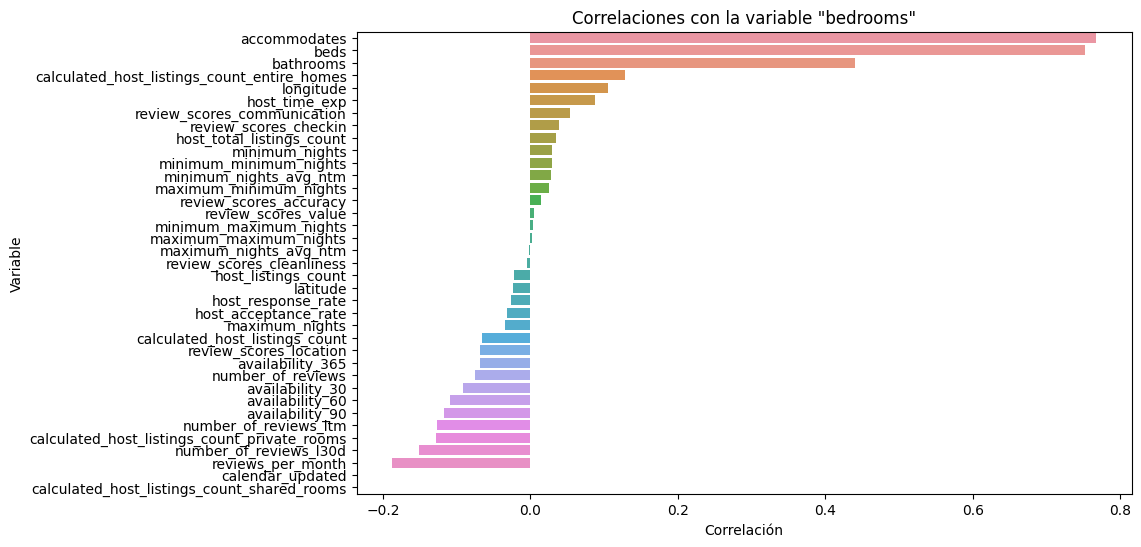

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las correlaciones con la variable "bedrooms"
correlations = df_val.corr()['bedrooms'].sort_values(ascending=False)

# Eliminar la correlación de "bedrooms" consigo misma
correlations = correlations.drop('bedrooms')

# Graficar las correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.title('Correlaciones con la variable "bedrooms"')
plt.show()


usaremos "beds//bathrooms//accommodates" para imputar, variables que logicamente estan relacionadas con la cantidad de dormitorios.

In [107]:
import pandas as pd
import numpy as np

# Paso 1: Filtrar filas con valores faltantes en "bedrooms"
missing_bedrooms = df_val[df_val['bedrooms'].isnull()]

# Paso 2: Iterar sobre las filas faltantes y buscar valores similares en las otras variables
for index, row in missing_bedrooms.iterrows():
    beds = row['beds']
    bathrooms = row['bathrooms']
    accommodates = row['accommodates']
    
    # Paso 3: Filtrar filas con valores similares en las otras variables
    similar_rows = df_val[(df_val['beds'] == beds) & (df_val['bathrooms'] == bathrooms) & (df_val['accommodates'] == accommodates)]
    
    # Paso 4: Imputar el valor mediano de "bedrooms" de las filas similares
    median_bedrooms = similar_rows['bedrooms'].median()
    df_val.loc[index, 'bedrooms'] = median_bedrooms

#quedan algunos sin imputar asiq lo hacemos con la moda = mediana 

# Calcular la moda general de la variable "bedrooms"
mode_bedrooms = df_val['bedrooms'].mode()[0]

# Imputar los valores faltantes con la moda general
df_val['bedrooms'].fillna(mode_bedrooms, inplace=True)

df_val['bedrooms'].isna().sum()



0



*   beds (70) --> imputamos en relacion a bathrooms bedrooms y accommodates



hacemos un test de correlacion de beds con otras variables para saber con cuales es logico imputar

<ipython-input-108-726f71a62d93>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df_val.corr()['beds'].sort_values(ascending=False)


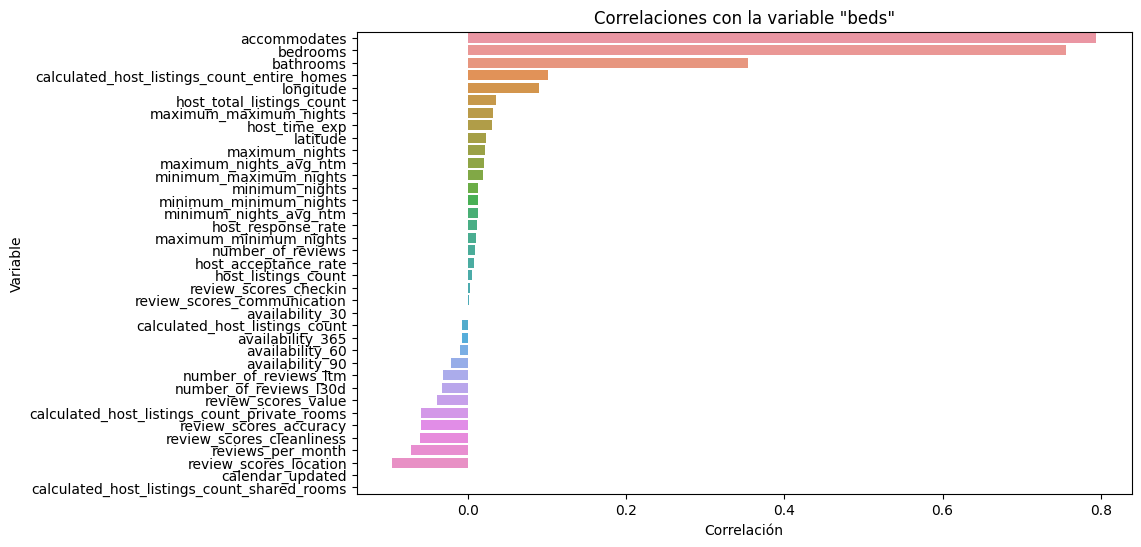

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las correlaciones con la variable "bedrooms"
correlations = df_val.corr()['beds'].sort_values(ascending=False)

# Eliminar la correlación de "beds" consigo misma
correlations = correlations.drop('beds')

# Graficar las correlaciones
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.title('Correlaciones con la variable "beds"')
plt.show()

usamos entonces bedrooms//bathrooms//accommodates para imputar

In [109]:
import pandas as pd
import numpy as np

# Paso 1: Filtrar filas con valores faltantes en "bedrooms"
missing_bedrooms = df_val[df_val['beds'].isnull()]

# Paso 2: Iterar sobre las filas faltantes y buscar valores similares en las otras variables
for index, row in missing_bedrooms.iterrows():
    bedrooms = row['bedrooms']
    bathrooms = row['bathrooms']
    accommodates = row['accommodates']
    
    # Paso 3: Filtrar filas con valores similares en las otras variables
    similar_rows = df_val[(df_val['bedrooms'] == bedrooms) & (df_val['bathrooms'] == bathrooms) & (df_val['accommodates'] == accommodates)]
    
    # Paso 4: Imputar el valor mediano de "beds" de las filas similares
    median_bedrooms = similar_rows['beds'].median()
    df_val.loc[index, 'beds'] = median_bedrooms

#quedan algunos sin imputar asiq lo hacemos con la moda = mediana 

# Calcular la moda general de la variable "beds"
mode_bedrooms = df_val['beds'].mode()[0]

# Imputar los valores faltantes con la moda general
df_val['beds'].fillna(mode_bedrooms, inplace=True)

df_val['beds'].isna().sum()

0

hay 4 filas que tienen missing en las siguientes variables:

review_scores_accuracy

review_scores_cleanliness

review_scores_checkin

review_scores_communication

review_scores_location

review_scores_value

***se descartan de la base.***

In [110]:
#df_val.dropna(subset=['review_scores_cleanliness'], inplace=True)


todos los campos de calendar_updated son missings, descartamos por ahora la variable 

In [111]:
df_val.drop('calendar_updated', axis=1, inplace=True)


**Asi queda el df_val sin datos nulos ni missings**

In [112]:
print("datos nulos: ")
print(df_val.isnull().sum().sum())


datos nulos: 
0


### Outliers

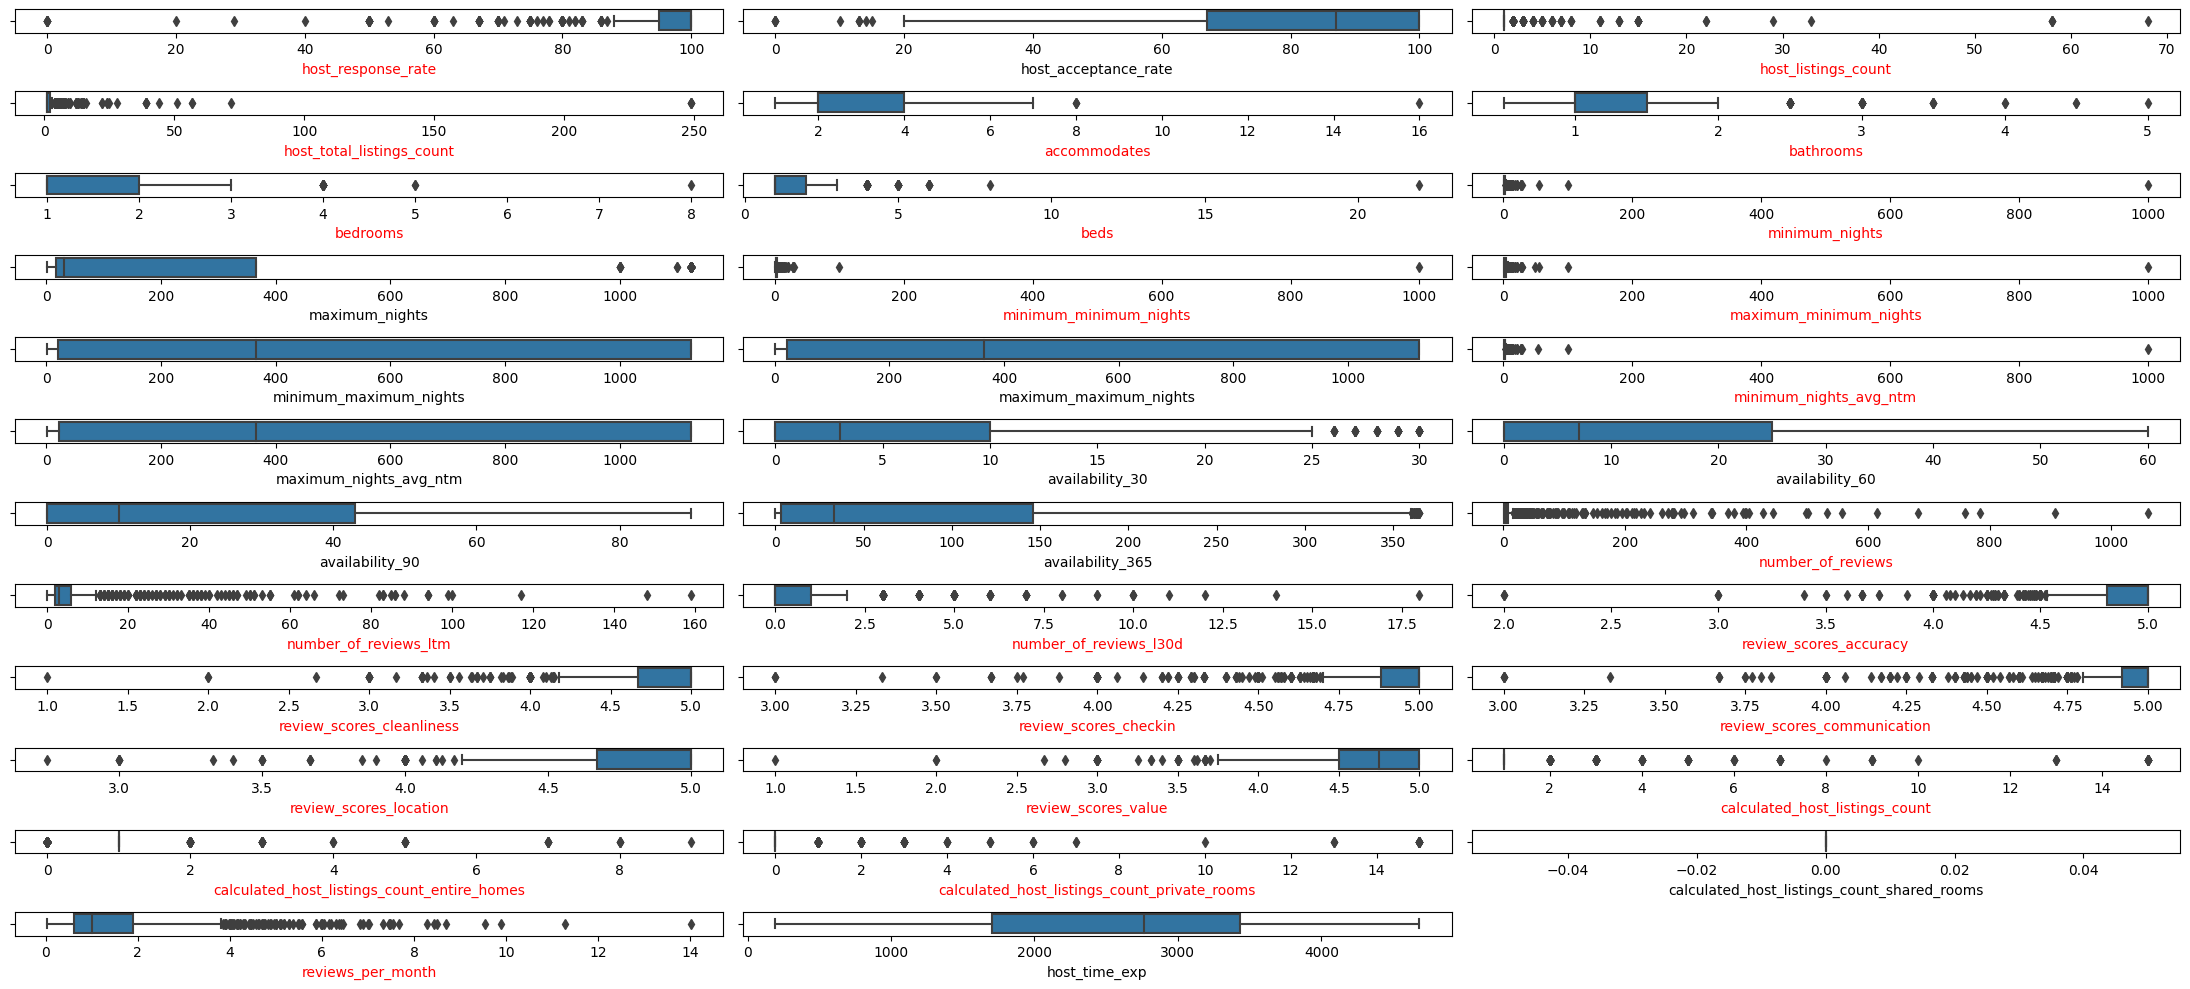

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'df_val' con todas tus variables

# Filtra solo las columnas numéricas
numeric_columns = df_val.select_dtypes(include=[np.number]).columns

# Elimina las variables 'longitude' y 'latitude' de la lista de columnas numéricas
numeric_columns = numeric_columns.drop(['longitude', 'latitude'])

# Calcula el número de filas y columnas para el subplot
n_rows = int(np.ceil(len(numeric_columns) / 3))
n_cols = 3

# Crea el subplot con el tamaño deseado
fig, axs = plt.subplots(n_rows, n_cols, figsize=(22, 10))

# Itera sobre cada columna numérica y crea un boxplot en el subplot correspondiente
for i, column in enumerate(numeric_columns):
    row = i // n_cols
    col = i % n_cols
    
    # Crea el boxplot para la columna actual
    sns.boxplot(x=df_val[column], ax=axs[row, col])
    axs[row, col].set_xlabel(column)
    
    # Verifica si hay outliers en la columna actual
    q1 = df_val[column].quantile(0.25)
    q3 = df_val[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    has_outliers = any((df_val[column] < lower_bound) | (df_val[column] > upper_bound))
    
    # Si hay outliers, cambia el color del título a rojo
    if has_outliers:
        axs[row, col].set_xlabel(column, color='red')
    
# Elimina los subplots vacíos si hay menos variables que subplots
if len(numeric_columns) < n_rows * n_cols:
    for i in range(len(numeric_columns), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axs[row, col])

# Ajusta el espaciado entre los subplots
fig.tight_layout()

# Muestra el gráfico de cajas
plt.show()



A simple vista se ven algunos outliers en varias variables pero ninguno parece representar un valor imposible o poco probable, se tiene en cuenta que debe haber hosts de airbnb con muchos rentas distintas muy grandes que van a destacar por sobre otros que posean una sola propiedad.

*    host listings count 

In [114]:
#df_val[df_val['host_listings_count']>100].sort_values(by='host_listings_count',ascending=False).head(20)




In [115]:
#df_val = df_val.drop(df_val[df_val['host_listings_count']>100].index)

no parecen ser casos irreales, pero si pueden complicar el modelo, por lo que se eliminan algunos valores extremos

*    host total listings count

In [116]:
#df_val[df_val['host_total_listings_count']>400].sort_values(by='host_total_listings_count',ascending=False).head(20)


In [117]:
#df_val = df_val.drop(df_val[df_val['host_total_listings_count']>400].index)

*   number_of_reviews


In [118]:
#df_val[df_val['number_of_reviews']>1000].sort_values(by='number_of_reviews',ascending=False).head(20)


In [119]:
#df_val = df_val.drop(df_val[df_val['number_of_reviews']>1000].index)

*   number of reviews ltm
*   number of reviews l30d

---
con el ajuste de la var anterior se fueron los extremos


In [120]:
#df_val[df_val['number_of_reviews_l30d']>50].sort_values(by='number_of_reviews_ltm',ascending=False).head(20)


*    minimum nights

In [121]:
#df_val[df_val['minimum_nights']>200]

In [122]:
#df_val = df_val.drop(df_val[df_val['minimum_nights']>200].index)

*    minimum maximum nights

> se encontro que hay unicamente dos valores por encima de 1125, pero mas de dosmil que son =1125, por el momento eliminamos los dos extremos 



In [123]:
#df_val[df_val['minimum_maximum_nights']>1125]

In [124]:
#df_val = df_val.drop(df_val[df_val['minimum_maximum_nights']>1125].index)

### Creacion de Variables



*   Creamos host_country y host_city_or_state a partir de la host_location



In [125]:
host_location_counts = df_val['host_location'].value_counts()
print(host_location_counts.to_string())


Amsterdam, Netherlands       1125
Netherlands                    36
Nederland, CO                   7
Utrecht, Netherlands            7
London, United Kingdom          5
Groningen, Netherlands          4
Nieuwegein, Netherlands         3
Amstelveen, Netherlands         2
São Paulo, Brazil               2
Rotterdam, Netherlands          2
Milan, Italy                    2
Vinkeveen, Netherlands          2
The Hague, Netherlands          2
Paris, France                   2
Amersfoort, Netherlands         2
Hilversum, Netherlands          2
Dublin, Ireland                 1
Maastricht, Netherlands         1
Lisbon, Portugal                1
Tielt-Winge, Belgium            1
Heemstede, Netherlands          1
Zaandam, Netherlands            1
Landsmeer, Netherlands          1
Miami Beach, FL                 1
England, United Kingdom         1
Leidschendam, Netherlands       1
Millersville, PA                1
Haarlem, Netherlands            1
Delft, Netherlands              1
Porto, Portuga

In [126]:
def process_host_location(location):
    if ',' in location:
        city, country = location.split(',')
        if country.strip() in ['DC', 'IL', 'CA', 'RI', 'FL', 'CO', 'NY']:
            country = 'United States'
        return city.strip(), country.strip()
    else:
        return location.strip(), ''


df_val[['host_city_or_state', 'host_country']] = df_val['host_location'].apply(process_host_location).apply(pd.Series)




*   Creamos la variable price_num
y ajustamos outliers

(no cambiamos la categorica ya que quizas le demos uso a futuro)



In [127]:
# Remover caracteres no numéricos y convertir a float
df_val['price_num'] = df_val['price'].str.replace('[^\d.]', '', regex=True).astype(float)

# Verificar los resultados
print(df_val[['price', 'price_num']].head(50))

      price  price_num
0   $100.00      100.0
1   $325.00      325.0
2   $175.00      175.0
3   $190.00      190.0
4   $200.00      200.0
5   $180.00      180.0
6   $243.00      243.0
7   $130.00      130.0
8   $217.00      217.0
9   $150.00      150.0
10  $200.00      200.0
11  $110.00      110.0
12  $180.00      180.0
13  $135.00      135.0
14   $90.00       90.0
15   $60.00       60.0
16  $160.00      160.0
17  $386.00      386.0
18  $298.00      298.0
19  $230.00      230.0
20  $230.00      230.0
21  $339.00      339.0
22  $270.00      270.0
23  $269.00      269.0
24  $350.00      350.0
25  $225.00      225.0
26  $399.00      399.0
27  $529.00      529.0
28  $300.00      300.0
29  $195.00      195.0
30  $200.00      200.0
31  $160.00      160.0
32  $149.00      149.0
33  $180.00      180.0
34  $230.00      230.0
35  $165.00      165.0
36  $120.00      120.0
37  $240.00      240.0
38  $250.00      250.0
39  $262.00      262.0
40  $195.00      195.0
41  $180.00      180.0
42  $172.00

*   price_num

In [128]:
df_val[df_val['price_num']>5000]

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_time_exp,host_city_or_state,host_country,price_num
997,739835979540372406,city scrape,Spacious central apartment - one bedroom,Welcome to Amsterdam!<br /><br />This is my fl...,none,7436952,Celine,2013-07-12,"Amsterdam, Netherlands","Hello there,\nI'm French, I love to travel, me...",within a few hours,100.0,100.0,f,unknown,2,3,"['email', 'phone', 'work_email']",t,t,unknown,Bos en Lommer,52.384758,4.851763,Private room in condo,Private room,2,1.0,1 shared bath,1.0,2.0,"[""Smoke alarm"", ""Kitchen"", ""Wifi"", ""Washer"", ""...","$9,198.00",3,15,3,3,1125,1125,3.0,1125.0,t,0,6,36,36,2022-12-05,1,1,1,2022-11-14,2022-11-14,5.0,5.0,5.0,5.0,5.0,5.0,Z222 0817 4600 0000 0000,f,1,0,1,0,1.0,3616,Amsterdam,Netherlands,9198.0


In [129]:
#df_val = df_val.drop(df_val[df_val['price_num']>5000].index)

*  Creamos host_time_exp que me dice los dias de experiencia que tiene siendo host a partir de la host_since y hoy. 

In [130]:
import datetime

df_val['host_since'] = pd.to_datetime(df_val['host_since'])


now = datetime.datetime.now()
df_val['host_time_exp'] = (now - df_val['host_since']).dt.days




*   Creamos la variable shared_bathrooms que dice 1 si hay banos compartidos y 0 si son banos privados a partir de bathrooms_text



In [131]:
df_val['shared_bathrooms'] = df_val['bathrooms_text'].str.contains('shared', case=False).astype(int)


In [132]:
def count_unique_values_and_top_values(df_val):
    # Obtener las columnas categóricas
    categorical_columns = df_val.select_dtypes(include='object').columns.tolist()

    # Crear un diccionario para almacenar los resultados
    result = {}

    # Contar los valores únicos y obtener los 5 valores más comunes en cada columna categórica
    for column in categorical_columns:
        unique_values = df_val[column].nunique()
        top_values = df_val[column].value_counts().head(5).index.tolist()
        result[column] = {'unique_values': unique_values, 'top_values': top_values}

    return result

    # Obtener la cantidad de valores únicos en cada columna categórica
result = count_unique_values_and_top_values(df_val)

# Imprimir los resultados
for column, count in result.items():
    print(f"{column}: {count}")

id: {'unique_values': 1233, 'top_values': ['568520730880917893', '709002225629789827', '709738017491963991', '709418770221956237', '709323658047095064']}
source: {'unique_values': 2, 'top_values': ['city scrape', 'previous scrape']}
name: {'unique_values': 1225, 'top_values': ['Appartement in de Pijp', 'Cosy apartment in the heart of Amsterdam', 'Mooi appartement in Amsterdam Oost', 'High-end boutique studio near city center!', 'Beautiful appartement in the heart of Amsterdam']}
description: {'unique_values': 1221, 'top_values': ['This private apartment (not a room) is fully equipped with everything you need to cook, live & sleep! Party-time with loud music, drinks and weed...? No Sir! For this kind of fun this apt is not suitable...we are very strict on that. Also important: no pets!<br /><br />Take a look at the area with this video - just use this link:<br />https://www.dropbox.com/s/zdb4arcxa1pswxq/5ed35d99-955e-4274-a890-27ff807fab6a.MP4?dl=0<br /><br /><b>The space</b><br />The i

In [133]:



def count_unique_values(df_val):
    # Obtener las columnas categóricas
    categorical_columns = df_val.select_dtypes(include='object').columns.tolist()

    # Crear un diccionario para almacenar los resultados
    unique_values = {}

    # Contar los valores únicos en cada columna categórica
    for column in categorical_columns:
        unique_values[column] = df_val[column].nunique()

    return unique_values


# Obtener la cantidad de valores únicos en cada columna categórica
result = count_unique_values(df_val)

# Imprimir los resultados
for column, count in result.items():
    print(f"{column}: {count}")


id: 1233
source: 2
name: 1225
description: 1221
neighborhood_overview: 549
host_id: 1158
host_name: 833
host_location: 44
host_about: 528
host_response_time: 5
host_is_superhost: 2
host_neighbourhood: 38
host_verifications: 7
host_has_profile_pic: 2
host_identity_verified: 2
neighbourhood: 8
neighbourhood_cleansed: 22
property_type: 35
room_type: 3
bathrooms_text: 17
amenities: 1220
price: 322
has_availability: 1
calendar_last_scraped: 1
first_review: 358
last_review: 229
license: 1120
instant_bookable: 2
host_city_or_state: 43
host_country: 14


*    creamos source_bin variable  1 = 'city scrape' 0 = 'previous scrape'

In [134]:
# Crear la variable source_bin
df_val['source_bin'] = df_val['source'].apply(lambda x: 1 if x == 'city scrape' else 0)

# Verificar los resultados
print(df_val['source_bin'].value_counts())
print(df_val['source'].value_counts())

1    939
0    294
Name: source_bin, dtype: int64
city scrape        939
previous scrape    294
Name: source, dtype: int64


*    creamos host_is_superhost_bin 1=t 0=f

In [135]:

# Función personalizada para asignar valores a host_is_superhost_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_is_superhost_bin
df_val['host_is_superhost_bin'] = df_val['host_is_superhost'].apply(map_superhost)

# Verificar los resultados
print(df_val['host_is_superhost_bin'].value_counts())
print(df_val['host_is_superhost'].value_counts())

0    1113
1     120
Name: host_is_superhost_bin, dtype: int64
f    1113
t     120
Name: host_is_superhost, dtype: int64




*   creamos host_has_profile_pic_bin   1=t 0=f



In [136]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_has_profile_pic_bin
df_val['host_has_profile_pic_bin'] = df_val['host_has_profile_pic'].apply(map_superhost)

# Verificar los resultados
print(df_val['host_has_profile_pic_bin'].value_counts())
print(df_val['host_has_profile_pic'].value_counts())


1    1214
0      19
Name: host_has_profile_pic_bin, dtype: int64
t    1214
f      19
Name: host_has_profile_pic, dtype: int64




*   creamos host_identity_verified_bin   1=t 0=f



In [137]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable host_identity_verified_bin
df_val['host_identity_verified_bin'] = df_val['host_identity_verified'].apply(map_superhost)

# Verificar los resultados
print(df_val['host_identity_verified_bin'].value_counts())
print(df_val['host_identity_verified'].value_counts())


1    1049
0     184
Name: host_identity_verified_bin, dtype: int64
t    1049
f     184
Name: host_identity_verified, dtype: int64




*   creamos has_availability_bin   1=t 0=f



In [138]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ['f', 'F']:
        return 0
    else:
        return None

# Crear la variable has_availability_bin
df_val['has_availability_bin'] = df_val['has_availability'].apply(map_superhost)

# Verificar los resultados
print(df_val['has_availability_bin'].value_counts())
print(df_val['has_availability'].value_counts())


1    1233
Name: has_availability_bin, dtype: int64
t    1233
Name: has_availability, dtype: int64




*   creamos calendar_last_scraped_bin   1= '2022-12-05'  0= '2022-12-17'



In [139]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['2022-12-05', 'T']:
        return 1
    elif value in ['2022-12-17', 'F']:
        return 0
    else:
        return None

# Crear la variable calendar_last_scraped_bin
df_val['calendar_last_scraped_bin'] = df_val['calendar_last_scraped'].apply(map_superhost)

# Verificar los resultados
print(df_val['calendar_last_scraped_bin'].value_counts())
print(df_val['calendar_last_scraped'].value_counts())


1    1233
Name: calendar_last_scraped_bin, dtype: int64
2022-12-05    1233
Name: calendar_last_scraped, dtype: int64




*   creamos instant_bookable_bin   1= t  0= f



In [140]:
# Función personalizada para asignar valores a blablabal_bin
def map_superhost(value):
    if value in ['t', 'T']:
        return 1
    elif value in ["f", 'F']:
        return 0
    else:
        return None

# Crear la variable instant_bookable_bin
df_val['instant_bookable_bin'] = df_val['instant_bookable'].apply(map_superhost)

# Verificar los resultados
print(df_val['instant_bookable_bin'].value_counts())
print(df_val['instant_bookable'].value_counts())


0    989
1    244
Name: instant_bookable_bin, dtype: int64
f    989
t    244
Name: instant_bookable, dtype: int64


*  host_verifications

---
se crearan 3 variables binarias para indicar si se posee o no esa verificacion y 1 variable mas que cuenta la cantidad de verificaciones


In [141]:
df_val['host_verifications'].unique()

array(["['email', 'phone']", "['phone']",
       "['email', 'phone', 'work_email']", "['phone', 'work_email']",
       '[]', "['email']", "['email', 'phone', 'photographer']"],
      dtype=object)

In [142]:


# Obtener las verificaciones únicas
unique_verifications = ['phone', 'email', 'work_email']

# Crear las columnas binarias
for verification in unique_verifications:
    df_val[f'has_{verification}'] = 0

# Agregar la columna verification_count
df_val['verification_count'] = 0

# Función para contar la cantidad de verificaciones
def count_verifications(verifications):
    return len(verifications)

# Recorrer la columna "host_verifications" y establecer los valores de las columnas binarias y verification_count
for i, row in df_val.iterrows():
    verifications = row['host_verifications']
    df_val.at[i, 'verification_count'] = count_verifications(verifications)
    for verification in unique_verifications:
        if verification in verifications:
            df_val.at[i, f'has_{verification}'] = 1


**Frequency Encoding**


---

realizaremos prueba con frequency encoding para los campos en los que se tiene una cantidad de entre 3 y 110 valores posibles.




'host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood',
                         'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text',
                         'host_city_or_state', 'host_country'

In [143]:
categorias = df_val.select_dtypes(include='object').columns.tolist()

result_freq = [categoria for categoria in categorias if 3 <= df_val[categoria].nunique() <= 110]
print(result_freq)

['host_location', 'host_response_time', 'host_neighbourhood', 'host_verifications', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'host_city_or_state', 'host_country']


In [144]:
# Variables a las que se les aplicará frequency encoding
variables_categoricas = ['host_location', 'host_response_time', 'host_neighbourhood', 'neighbourhood',
                         'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text',
                         'host_city_or_state', 'host_country']

# Iterar sobre las variables y aplicar frequency encoding
for variable in variables_categoricas:
    frecuencias = df_val[variable].value_counts(normalize=True)  # Calcular las frecuencias relativas
    df_val[f'{variable}_freq_encoded'] = df_val[variable].map(frecuencias)  # Mapear las frecuencias a cada categoría


In [145]:
df_val.shape

(1233, 91)

*   amenities ---> se crean variables binarias para los amenities mas comunes, las mismas indicaran si tiene o no ese amenity.

* se crea la amenities_counts que indica cuantas amenities tiene. 

In [146]:
amenities_list = ['Essentials', 'Smoke alarm', 'Wifi', 'Heating', 'Hot water', 'Hangers', 'Hair dryer', 'Kitchen', 'Dishes and silverware', 'Refrigerator', 'Iron', 'Long term stays allowed', 'Shampoo', 'Bed linens', 'Cooking basics', 'Carbon monoxide alarm', 'Coffee maker', 'Fire extinguisher', 'Dishwasher', 'Washer', 'Private entrance', 'First aid kit', 'Oven', 'Microwave', 'Stove', 'Dedicated workspace', 'Extra pillows and blankets', 'TV', 'Host greets you', 'Luggage dropoff allowed', 'Cleaning products', 'Shower gel', 'Dryer', 'Wine glasses', 'Dining table']

# Crear variables binarias para cada amenidad
for amenity in amenities_list:
    df_val['has_' + amenity.lower().replace(" ", "_") + '_bin'] = df_val['amenities'].str.contains(amenity, case=False).astype(int)


In [147]:
df_val['amenities_counts'] = df_val['amenities'].apply(lambda x: len(x.split(',')))


*   has_description_bin 
*   has_neighborhood_bin
*   has_neighbourhood_overview_bin
*   has_host_neighbourhood_bin
*   has_host_about_bin








In [148]:
variables = ['description', 'neighbourhood', 'neighborhood_overview', 'host_neighbourhood', 'host_about']

for var in variables:
    df_val[var + '_bin'] = df_val[var].apply(lambda x: 0 if x in ['unknown', 'none'] else 1)


*   host_response_time  ordinal encoding

In [149]:
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    'unknown': 0
}

df_val['host_response_time_ord'] = df_val['host_response_time'].map(response_time_mapping)


property_type  sacamos si tiene la palabra "entire", si tiene la palabra "private" o "shared" 

In [150]:
df_val['property_type_shared_bin'] = df_val['property_type'].str.contains('Shared', case=False).astype(int)
df_val['property_type_entire_bin'] = df_val['property_type'].str.contains('Entire', case=False).astype(int)
df_val['property_type_private_bin'] = df_val['property_type'].str.contains('Private', case=False).astype(int)


time since first review

time since last review

time between review

In [151]:
import pandas as pd

# Convertir las variables de fecha al formato adecuado
df_val['first_review'] = pd.to_datetime(df_val['first_review'])
df_val['last_review'] = pd.to_datetime(df_val['last_review'])

# Calcular la diferencia en días desde la primera revisión
df_val['time_since_first_review'] = (pd.to_datetime('today') - df_val['first_review']).dt.days

# Calcular la diferencia en días desde la última revisión
df_val['time_since_last_review'] = (pd.to_datetime('today') - df_val['last_review']).dt.days

# Calcular la diferencia en días entre la primera y última revisión
df_val['time_between_first_last_review'] = (df_val['last_review'] - df_val['first_review']).dt.days


# **Armar submit**

In [160]:
resultado = extra_model.predict(df_val[model_num_columns])

res = pd.DataFrame(data={"review_scores_rating": resultado}).astype(str)
res.index = df_val.id
res.to_csv("res.csv", sep=',',index=True,  index_label='id')